In [154]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, make_scorer, f1_score, precision_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, roc_auc_score

In [155]:
#!/bin/bash
!kaggle datasets download prachi13/customer-analytics

Dataset URL: https://www.kaggle.com/datasets/prachi13/customer-analytics
License(s): other
customer-analytics.zip: Skipping, found more recently modified local copy (use --force to force download)


In [156]:
import os

HOME = os.getcwd()
# 압축 파일의 위치
zipPath = os.path.join(HOME, 'customer-analytics.zip')
# 압축 해제 할 위치
targetPath = os.path.join(HOME, 'data')

In [157]:
from zipfile import ZipFile

with ZipFile(zipPath, 'r') as zip_ref:
    zip_ref.extractall(targetPath)

In [158]:
trainPath = os.path.join(targetPath, 'Train.csv')
df = pd.read_csv(trainPath)
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [160]:
df.describe()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,3175.28214,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,2750.50000,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,5500.00000,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,8249.50000,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,10999.00000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


In [161]:
# List of categorical and discrete features
cat_cols = [
    'Warehouse_block', 
    'Mode_of_Shipment', 
    'Product_importance', 
    'Gender', 
    ]

num_cols = [
    'Customer_care_calls', 
    'Customer_rating',
    'Cost_of_the_Product',
    'Prior_purchases',
    'Discount_offered',
    'Weight_in_gms'   
]

In [162]:
from sklearn.model_selection import train_test_split

# 1. stratify 옵션을 써서 정답(Reached.on.Time_Y.N) 비율을 유지하며 8:2로 나눕니다.
# 이 함수는 내부적으로 데이터를 랜덤하게 섞어주기 때문에 sample을 따로 안 써도 됩니다.
part1, part2 = train_test_split(df, 
                                test_size=0.2, 
                                random_state=42, 
                                stratify=df['Reached.on.Time_Y.N'])

# 2. 각각 파일로 저장
part1.to_csv('data/train_df.csv', index=False)
part2.to_csv('data/test_df.csv', index=False)

print("데이터 분할 및 저장 완료!")
print(f"학습용: {part1.shape}, 테스트용: {part2.shape}")

데이터 분할 및 저장 완료!
학습용: (8799, 12), 테스트용: (2200, 12)


In [163]:
train_df = pd.read_csv('data/train_df.csv')
test_df = pd.read_csv('data/test_df.csv')
train_df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,7921,D,Road,4,1,261,2,medium,F,9,4158,0
1,1530,F,Ship,3,3,162,2,low,F,26,1659,1
2,10522,B,Ship,3,2,221,2,medium,M,9,4466,0
3,9559,D,Ship,3,5,157,4,medium,F,2,4640,0
4,969,A,Flight,2,5,272,2,low,M,24,3638,1


In [168]:
print(f"배송 지연 확률: {train_df['Reached.on.Time_Y.N'].mean() * 100:.2f}%")

배송 지연 확률: 59.67%


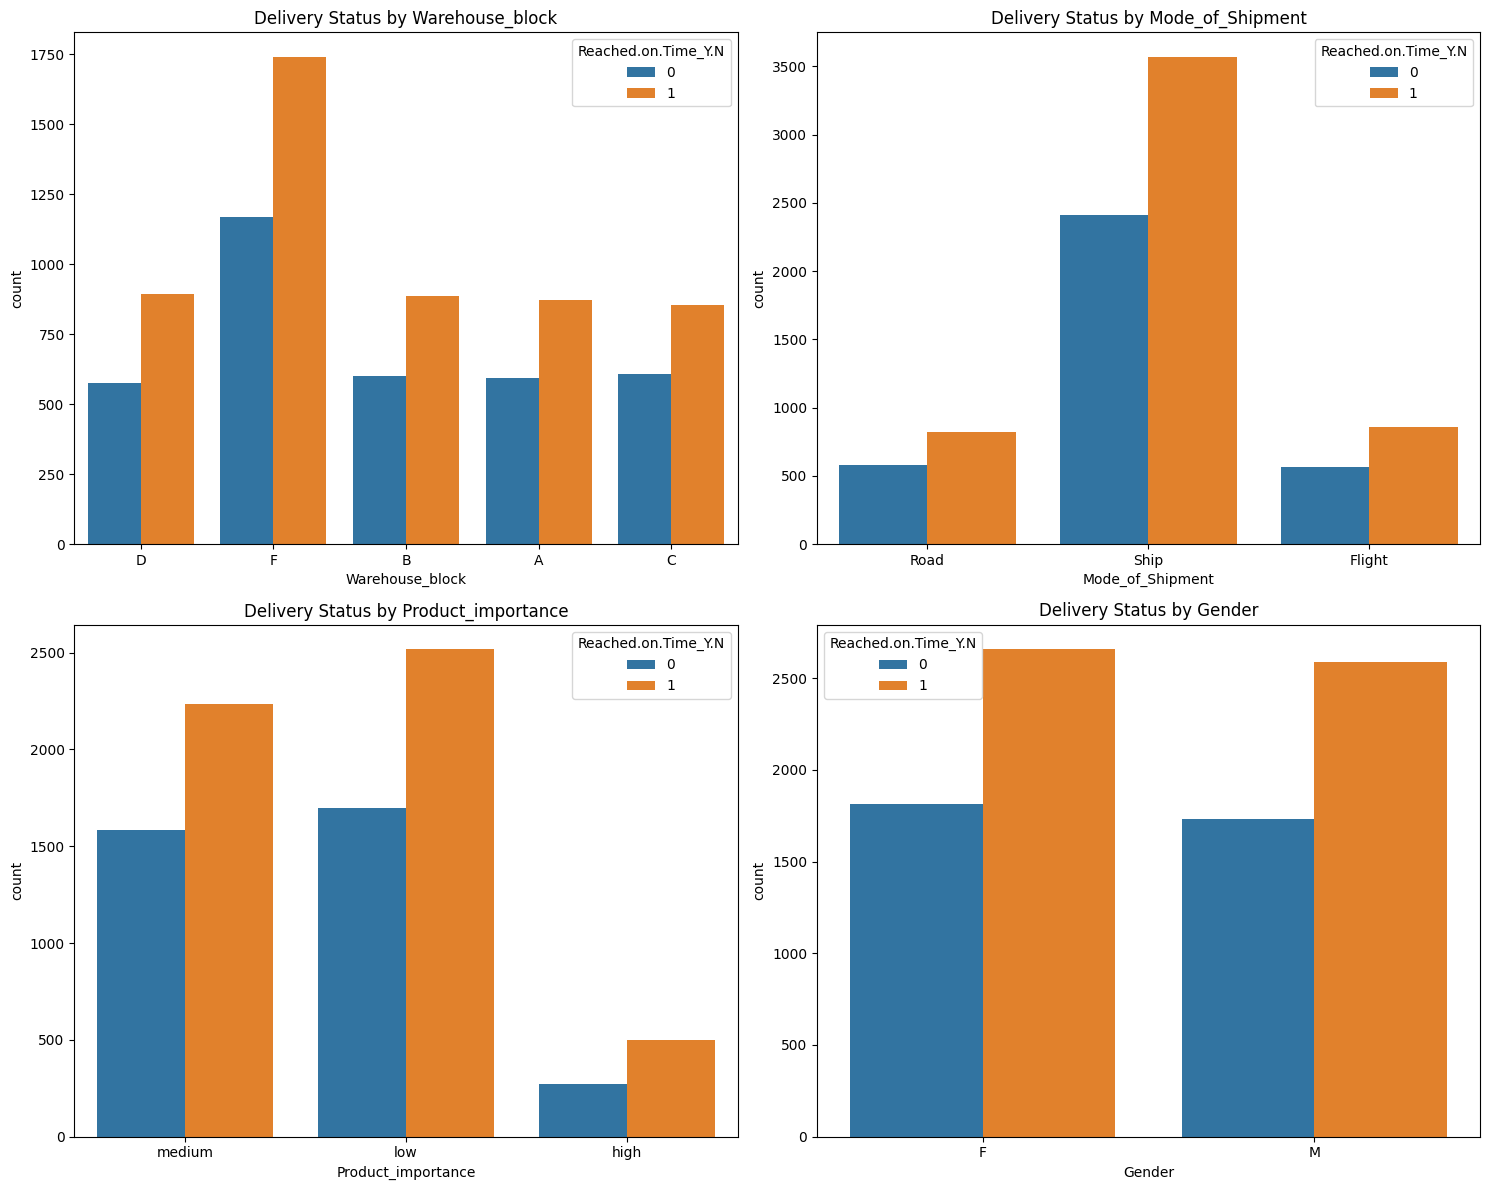

In [100]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(data=train_df, x=col, hue='Reached.on.Time_Y.N', ax=axes[i])
    axes[i].set_title(f'Delivery Status by {col}')

plt.tight_layout()
plt.show()

In [101]:


# Loop through each column and calculate the mean
for col in cat_cols:
    # Calculate the mean, multiply by 100, and format as a percentage string
    result = (train_df.groupby(col)['Reached.on.Time_Y.N'].mean() * 100).map("{:.2f}%".format).to_frame()
    
    print(f"--- Late Rate by {col} ---")
    display(result)

--- Late Rate by Warehouse_block ---


,Reached.on.Time_Y.N
Warehouse_block,
A,59.47%
B,59.65%
C,58.40%
D,60.82%
F,59.83%


--- Late Rate by Mode_of_Shipment ---


,Reached.on.Time_Y.N
Mode_of_Shipment,
Flight,60.42%
Road,58.73%
Ship,59.71%


--- Late Rate by Product_importance ---


,Reached.on.Time_Y.N
Product_importance,
high,64.84%
low,59.75%
medium,58.53%


--- Late Rate by Gender ---


,Reached.on.Time_Y.N
Gender,
F,59.42%
M,59.92%


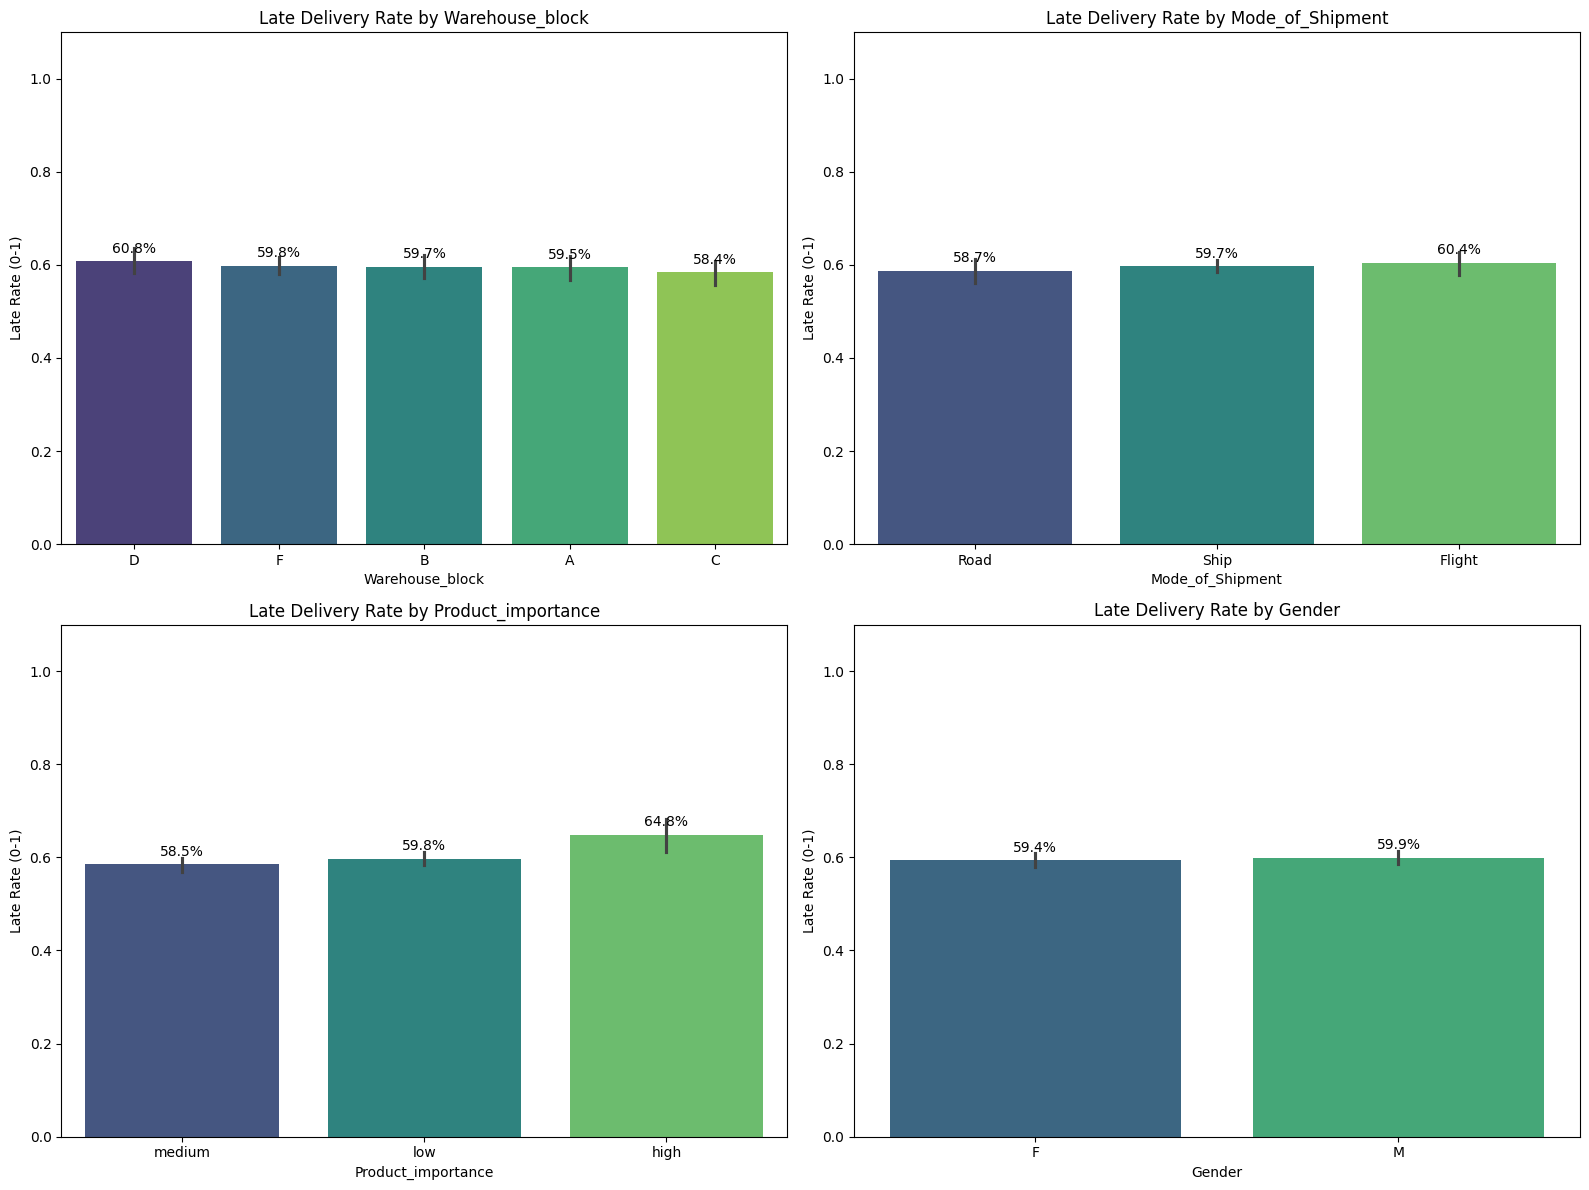

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the figure with a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12)) # Height adjusted for a 2x2 layout
axes = axes.flatten()
for i, col in enumerate(cat_cols):
    sns.barplot(
        data=train_df, 
        x=col, 
        y='Reached.on.Time_Y.N', 
        ax=axes[i], 
        hue=col,            
        palette='viridis', 
        legend=False        
    )
    
    # Adding the percentage labels on top of the bars
    for p in axes[i].patches:
        height = p.get_height()
        axes[i].annotate(f'{height*100:.1f}%', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', 
                        xytext=(0, 9), 
                        textcoords='offset points')
    axes[i].set_title(f'Late Delivery Rate by {col}')
    axes[i].set_ylabel('Late Rate (0-1)')
    axes[i].set_ylim(0, 1.1)
plt.tight_layout()
plt.show()

In [103]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8799 entries, 0 to 8798
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   8799 non-null   int64 
 1   Warehouse_block      8799 non-null   object
 2   Mode_of_Shipment     8799 non-null   object
 3   Customer_care_calls  8799 non-null   int64 
 4   Customer_rating      8799 non-null   int64 
 5   Cost_of_the_Product  8799 non-null   int64 
 6   Prior_purchases      8799 non-null   int64 
 7   Product_importance   8799 non-null   object
 8   Gender               8799 non-null   object
 9   Discount_offered     8799 non-null   int64 
 10  Weight_in_gms        8799 non-null   int64 
 11  Reached.on.Time_Y.N  8799 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 825.0+ KB


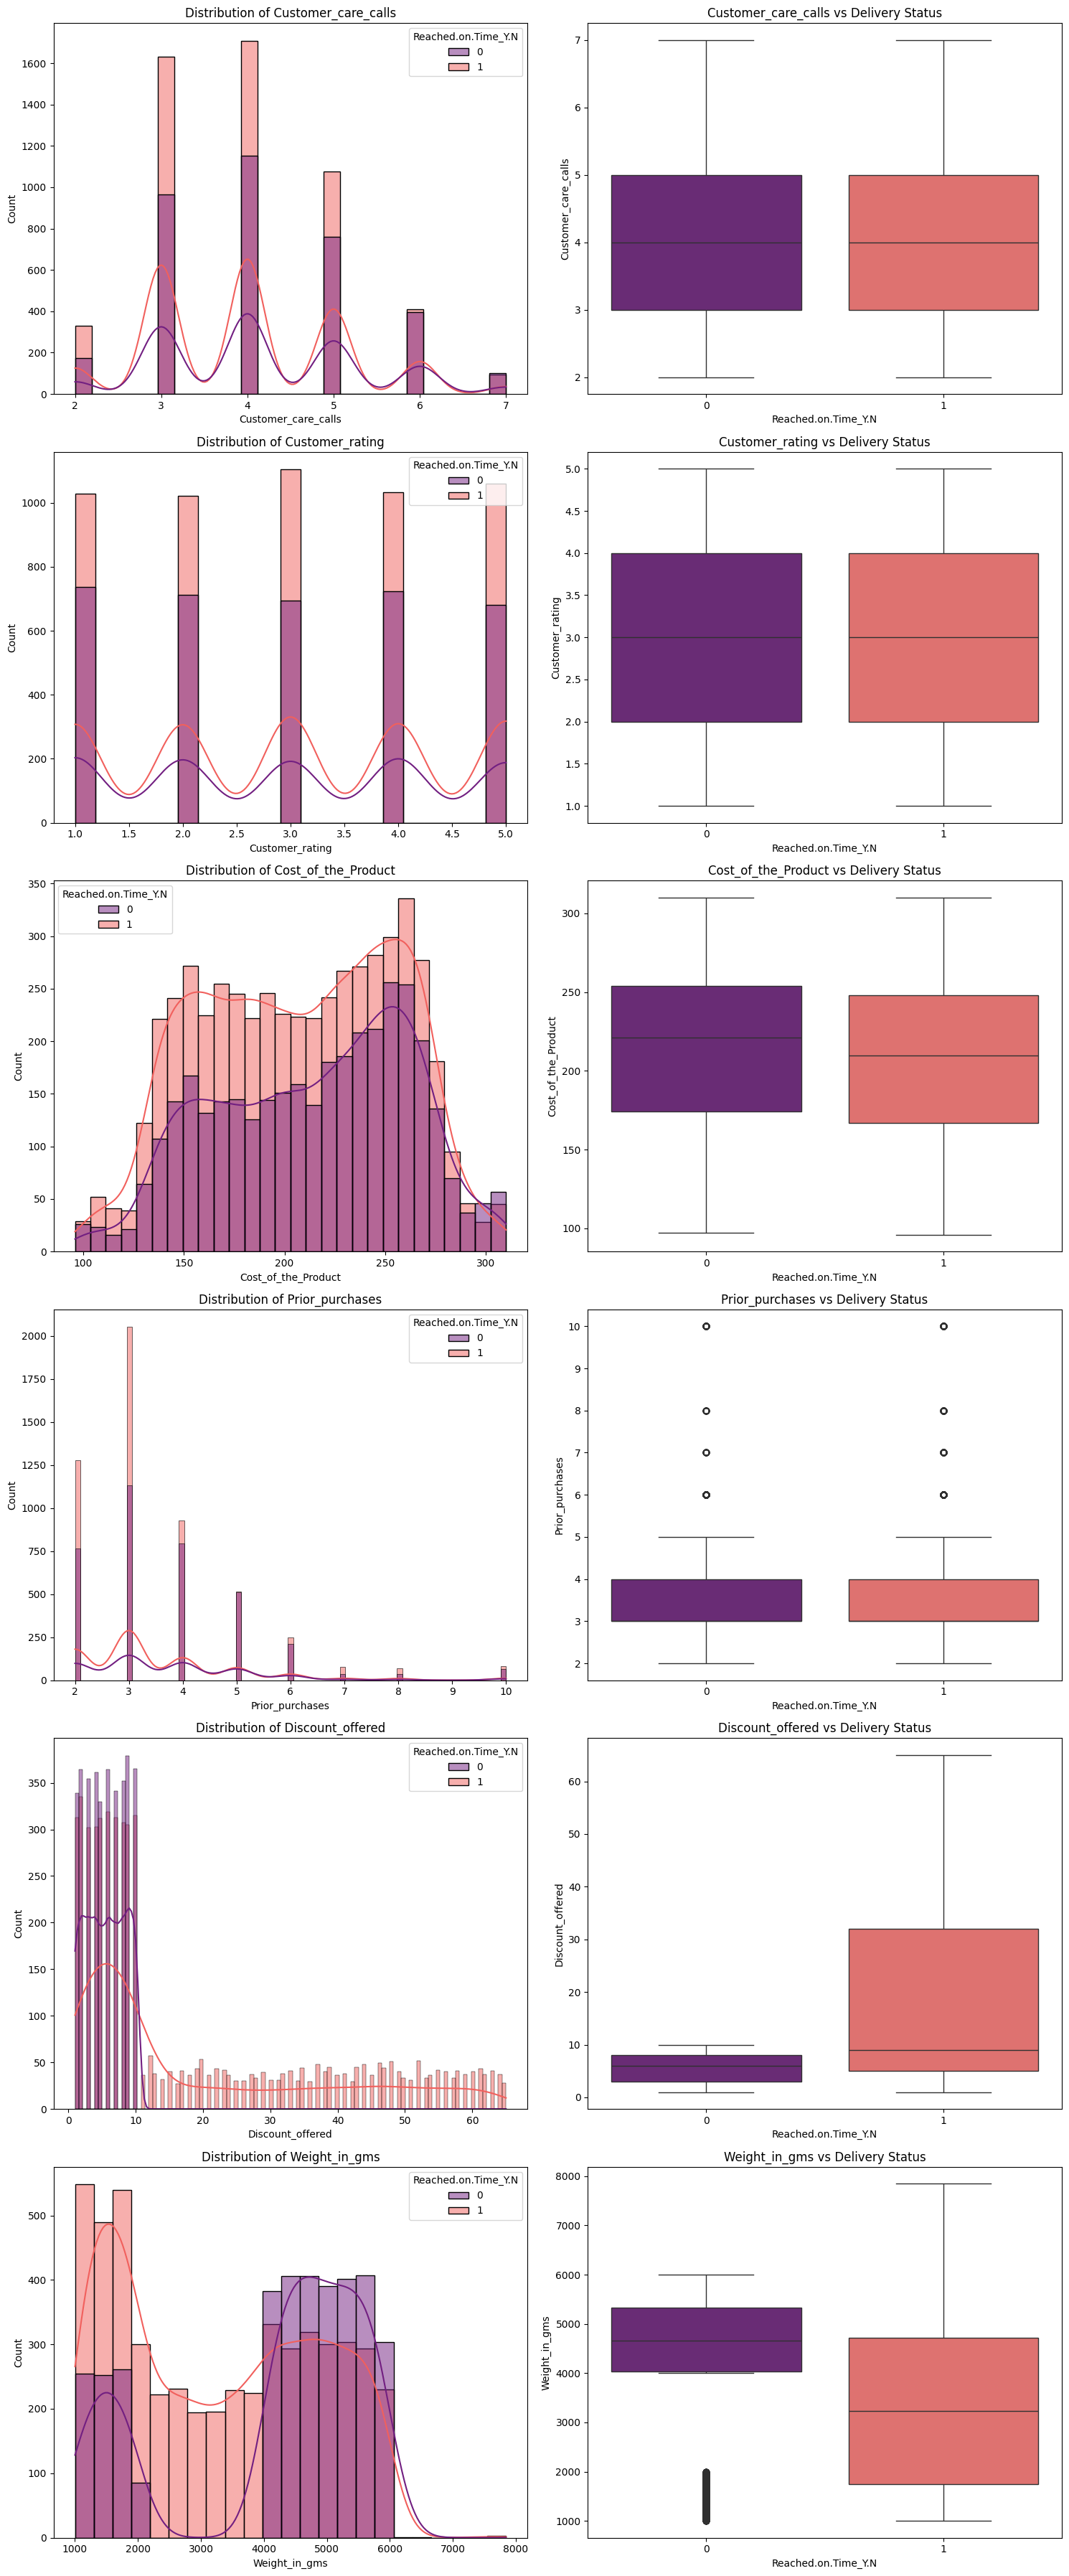

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# num_cols가 현재 4개인 것으로 보입니다. (예: ID나 다른 변수가 포함됨)
# 갯수에 상관없이 작동하도록 행(rows)의 개수를 계산합니다.
n_features = len(num_cols)
rows = n_features
cols = 2

# 그래프 설정
fig, axes = plt.subplots(rows, cols, figsize=(15, 6 * rows))

# 리스트가 1개인 경우 axes가 1차원 배열이 되는 것을 방지하기 위해 2차원으로 정렬
if rows == 1:
    axes = axes.reshape(1, -1)

for i, col in enumerate(num_cols):
    # 1. 히스토그램 & KDE (분포 확인)
    sns.histplot(data=train_df, x=col, hue='Reached.on.Time_Y.N', kde=True, ax=axes[i, 0], palette='magma')
    axes[i, 0].set_title(f'Distribution of {col}')
    
    # 2. 박스 플롯 (이상치 및 중앙값 차이 확인)
    sns.boxplot(data=train_df, x='Reached.on.Time_Y.N', y=col, ax=axes[i, 1], palette='magma', hue='Reached.on.Time_Y.N', legend=False)
    axes[i, 1].set_title(f'{col} vs Delivery Status')

plt.tight_layout()
plt.show()

### EDA

C:\Users\ysj58\AppData\Local\Temp\ipykernel_8332\526946931.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




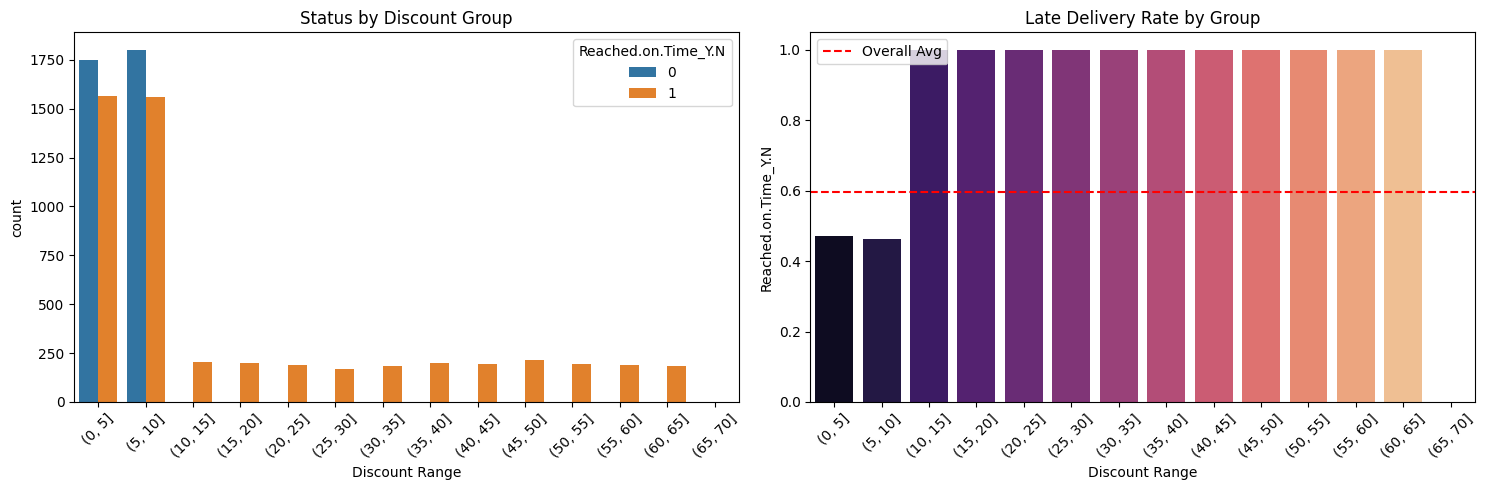

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 데이터 준비: 구간 설정 및 그룹 생성
max_discount = train_df['Discount_offered'].max()
bins = list(range(0, max_discount + 6, 5))
train_df['Discount_Group'] = pd.cut(train_df['Discount_offered'], bins=bins)

# 1행 2열 구조로 시각화 (크기 축소)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. 구간별 빈도수 시각화 (좌측)
sns.countplot(data=train_df, x='Discount_Group', hue='Reached.on.Time_Y.N', ax=axes[0])
axes[0].set_title('Status by Discount Group', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('Discount Range')

# 2. 구간별 지연율 시각화 (우측)
discount_late_rate = train_df.groupby('Discount_Group', observed=False)['Reached.on.Time_Y.N'].mean().reset_index()
sns.barplot(data=discount_late_rate, x='Discount_Group', y='Reached.on.Time_Y.N', palette='magma', ax=axes[1])
axes[1].set_title('Late Delivery Rate by Group', fontsize=12)
axes[1].axhline(train_df['Reached.on.Time_Y.N'].mean(), color='red', linestyle='--', label='Overall Avg')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xlabel('Discount Range')
axes[1].legend()

plt.tight_layout()
plt.show()

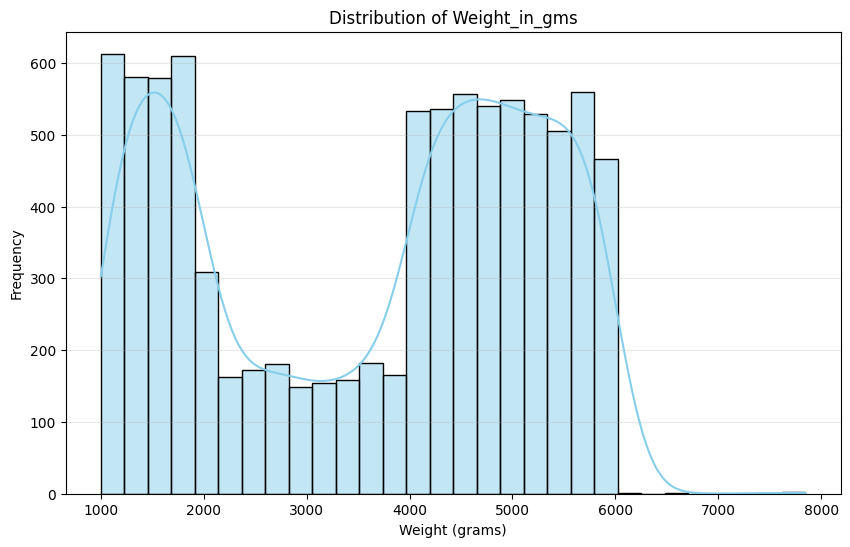

In [106]:
# 'Weight_in_gms' 히스토그램 시각화
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Weight_in_gms'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Weight_in_gms')
plt.xlabel('Weight (grams)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [107]:
train_df['rel_price'] = train_df['Cost_of_the_Product'] / train_df['Weight_in_gms']
display(train_df[['Cost_of_the_Product', 'Weight_in_gms', 'rel_price']].head())

,Cost_of_the_Product,Weight_in_gms,rel_price
0,261,4158,0.062771
1,162,1659,0.097649
2,221,4466,0.049485
3,157,4640,0.033836
4,272,3638,0.074766


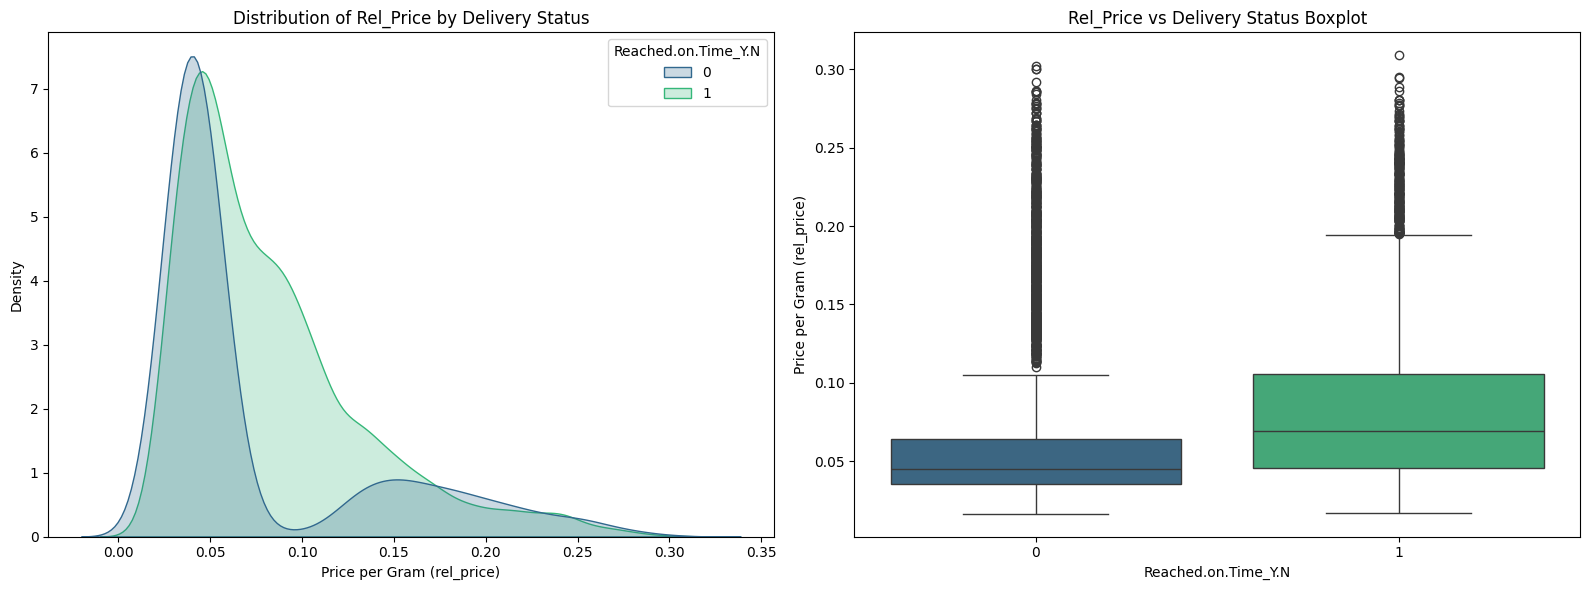

--- Average Rel_Price by Delivery Status ---


,rel_price
Reached.on.Time_Y.N,
0,0.073813
1,0.082960


In [108]:
# 시각화 설정
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. KDE Plot (분포 비교)
sns.kdeplot(data=train_df, x='rel_price', hue='Reached.on.Time_Y.N', fill=True, ax=axes[0], palette='viridis')
axes[0].set_title('Distribution of Rel_Price by Delivery Status')
axes[0].set_xlabel('Price per Gram (rel_price)')

# 2. Box Plot (통계적 차이 확인)
sns.boxplot(data=train_df, x='Reached.on.Time_Y.N', y='rel_price', ax=axes[1], palette='viridis', hue='Reached.on.Time_Y.N', legend=False)
axes[1].set_title('Rel_Price vs Delivery Status Boxplot')
axes[1].set_ylabel('Price per Gram (rel_price)')

plt.tight_layout()
plt.show()

# 추가: 평균값 수치 확인
print("--- Average Rel_Price by Delivery Status ---")
display(train_df.groupby('Reached.on.Time_Y.N')['rel_price'].mean().to_frame())

In [109]:
train_df['rel_price'].describe()

count    8799.000000
mean        0.079270
std         0.055991
min         0.016482
25%         0.039861
50%         0.055030
75%         0.103343
max         0.309073
Name: rel_price, dtype: float64

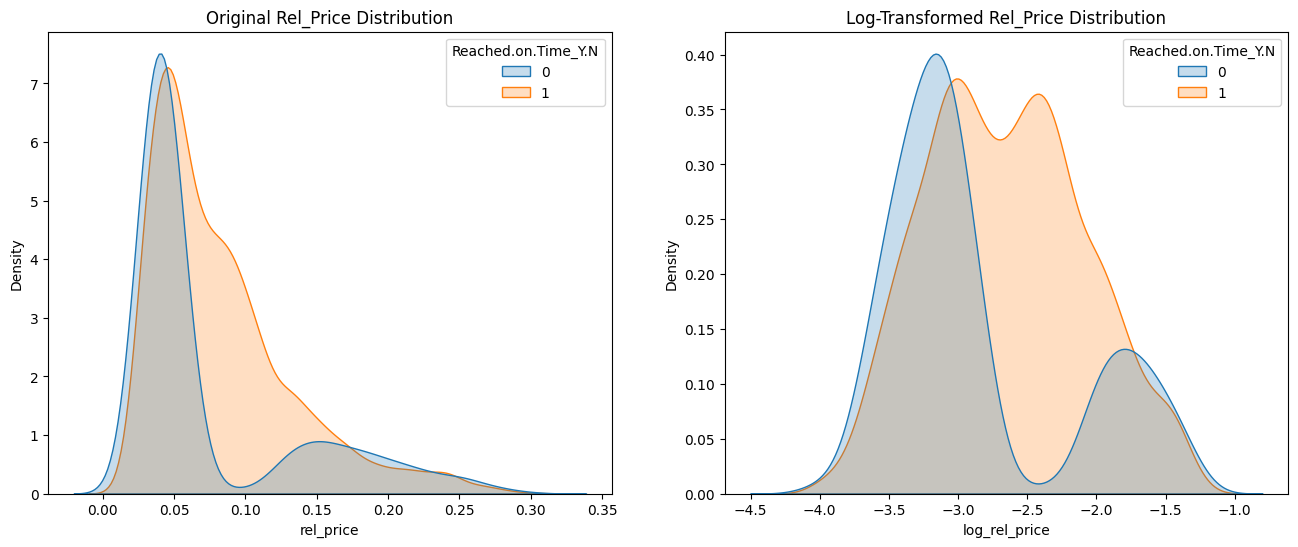

In [110]:
import numpy as np

# 로그 변환 적용 (0이 있을 경우를 대비해 1을 더하는 log1p 사용 가능하지만, 
# 여기서는 양수이므로 np.log 사용)
train_df['log_rel_price'] = np.log(train_df['rel_price'])

# 시각화 비교
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 변환 전
sns.kdeplot(data=train_df, x='rel_price', hue='Reached.on.Time_Y.N', fill=True, ax=axes[0])
axes[0].set_title('Original Rel_Price Distribution')

# 변환 후
sns.kdeplot(data=train_df, x='log_rel_price', hue='Reached.on.Time_Y.N', fill=True, ax=axes[1])
axes[1].set_title('Log-Transformed Rel_Price Distribution')

plt.show()

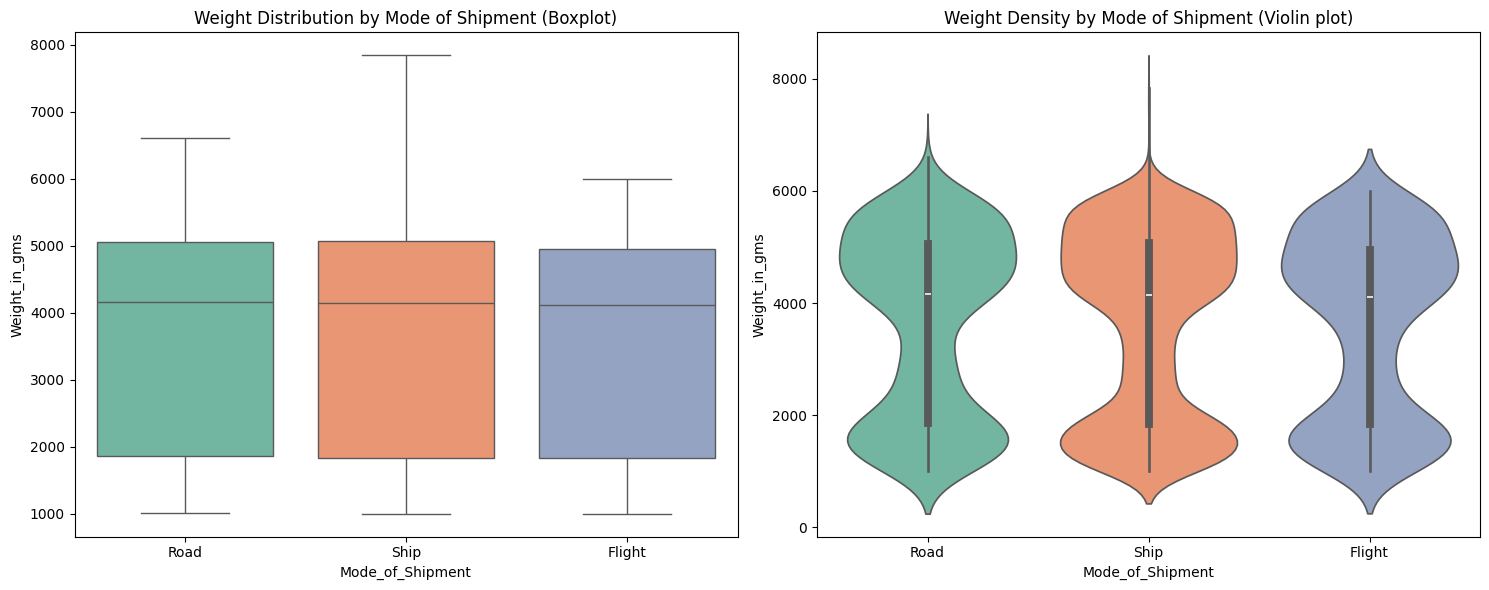

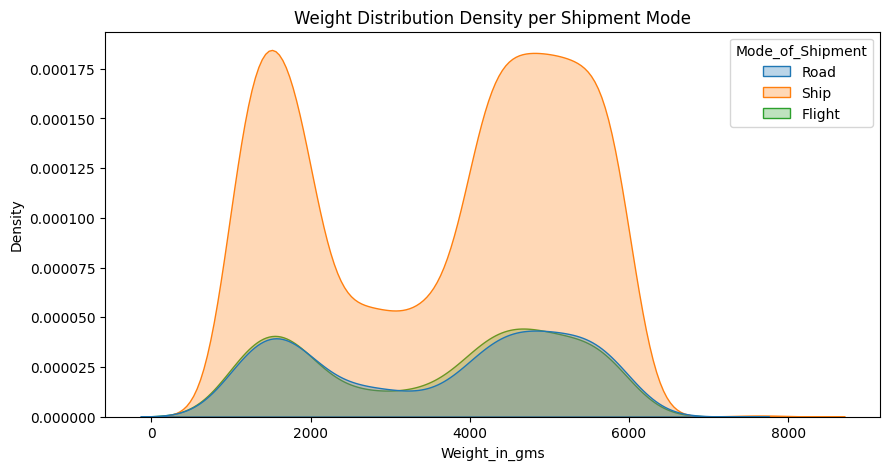

In [111]:
# Mode_of_Shipment와 Weight_in_gms 조합 시각화
plt.figure(figsize=(15, 6))

# 1. 박스플롯: 중앙값, 사분위수 및 이상치 확인
plt.subplot(1, 2, 1)
sns.boxplot(data=train_df, x='Mode_of_Shipment', y='Weight_in_gms', palette='Set2',hue='Mode_of_Shipment', legend=False)
plt.title('Weight Distribution by Mode of Shipment (Boxplot)')

# 2. 바이올린플롯: 전체적인 분포 밀도 확인
plt.subplot(1, 2, 2)
sns.violinplot(data=train_df, x='Mode_of_Shipment', y='Weight_in_gms', palette='Set2',hue='Mode_of_Shipment', legend=False)
plt.title('Weight Density by Mode of Shipment (Violin plot)')

plt.tight_layout()
plt.show()

# 3. 배송 수단별 무게 분포도 (FacetGrid/KDE)
plt.figure(figsize=(10, 5))
sns.kdeplot(data=train_df, x='Weight_in_gms', hue='Mode_of_Shipment', fill=True, alpha=0.3)
plt.title('Weight Distribution Density per Shipment Mode')
plt.show()

In [112]:
train_df['Mode_of_Shipment'].value_counts()

Mode_of_Shipment
Ship      5981
Flight    1420
Road      1398
Name: count, dtype: int64

--- 범주화 결과 (상위 5개) ---
   Weight_in_gms Weight_Category
0           4158           heavy
1           1659           light
2           4466           heavy
3           4640           heavy
4           3638          medium

--- Weight_Category 분포 ---
Weight_Category
heavy     4756
light     2592
medium    1451
Name: count, dtype: int64


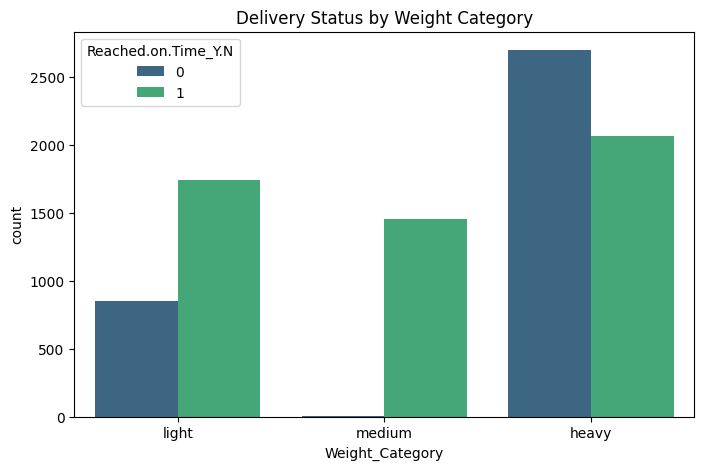

In [113]:
# 'Weight_in_gms' 범주화 (2000, 4000 기준)
# 2000 이하: light, 2000 초과 4000 이하: medium, 4000 초과: heavy
bins = [0, 2000, 4000, float('inf')]
labels = ['light', 'medium', 'heavy']

# train_df와 test_df 모두에 적용
train_df['Weight_Category'] = pd.cut(train_df['Weight_in_gms'], bins=bins, labels=labels)
test_df['Weight_Category'] = pd.cut(test_df['Weight_in_gms'], bins=bins, labels=labels)

# 결과 확인
print("--- 범주화 결과 (상위 5개) ---")
print(train_df[['Weight_in_gms', 'Weight_Category']].head())

# 범주별 분포 확인
print("\n--- Weight_Category 분포 ---")
print(train_df['Weight_Category'].value_counts())

# 시각화로 확인
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='Weight_Category', hue='Reached.on.Time_Y.N', palette='viridis')
plt.title('Delivery Status by Weight Category')
plt.show()

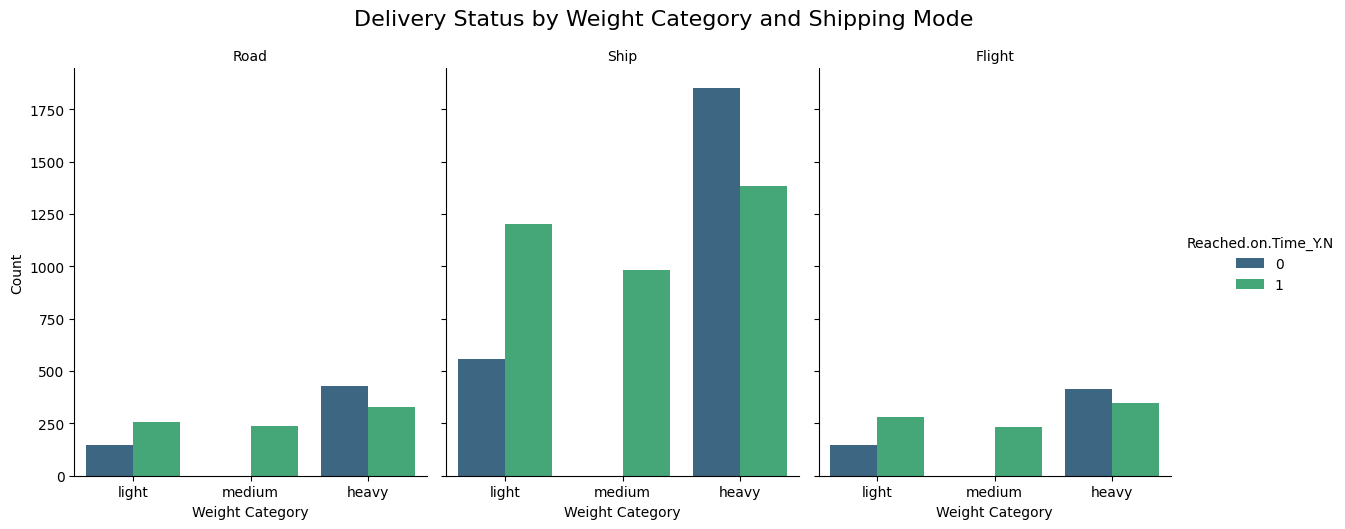

In [114]:
# 배송 수단별 무게 범주에 따른 배송 상태 시각화
g = sns.catplot(
    data=train_df, 
    x='Weight_Category', 
    hue='Reached.on.Time_Y.N', 
    col='Mode_of_Shipment', 
    kind='count',
    palette='viridis',
    height=5, 
    aspect=0.8
)

# 제목 및 라벨 조정
g.set_axis_labels("Weight Category", "Count")
g.set_titles("{col_name}")
g.fig.suptitle('Delivery Status by Weight Category and Shipping Mode', y=1.05, fontsize=16)

plt.show()

In [115]:
# observed=False를 추가하여 경고 해결
summary_table = train_df.groupby(['Mode_of_Shipment', 'Weight_Category'], observed=False)['Reached.on.Time_Y.N'].agg(['count', 'sum']).reset_index()

# 컬럼 명칭 변경
summary_table.columns = ['Mode_of_Shipment', 'Weight_Category', 'Total_Count', 'Late_Count']

# 지연율 계산
summary_table['Late_Rate'] = (summary_table['Late_Count'] / summary_table['Total_Count'] * 100).round(2).astype(str) + '%'

# 피벗 테이블 변환
pivot_summary = summary_table.pivot(index='Mode_of_Shipment', columns='Weight_Category', values='Late_Rate')

print("--- 배송 수단별 & 무게 범주별 지연율 (%) ---")
display(pivot_summary)

print("\n--- 상세 통계 (건수 포함) ---")
display(summary_table)

--- 배송 수단별 & 무게 범주별 지연율 (%) ---


Weight_Category,light,medium,heavy
Mode_of_Shipment,,,
Flight,65.49%,100.0%,45.61%
Road,63.46%,100.0%,43.33%
Ship,68.37%,99.9%,42.77%



--- 상세 통계 (건수 포함) ---


,Mode_of_Shipment,Weight_Category,Total_Count,Late_Count,Late_Rate
0,Flight,light,426,279,65.49%
1,Flight,medium,231,231,100.0%
2,Flight,heavy,763,348,45.61%
3,Road,light,405,257,63.46%
4,Road,medium,236,236,100.0%
5,Road,heavy,757,328,43.33%
6,Ship,light,1761,1204,68.37%
7,Ship,medium,984,983,99.9%
8,Ship,heavy,3236,1384,42.77%


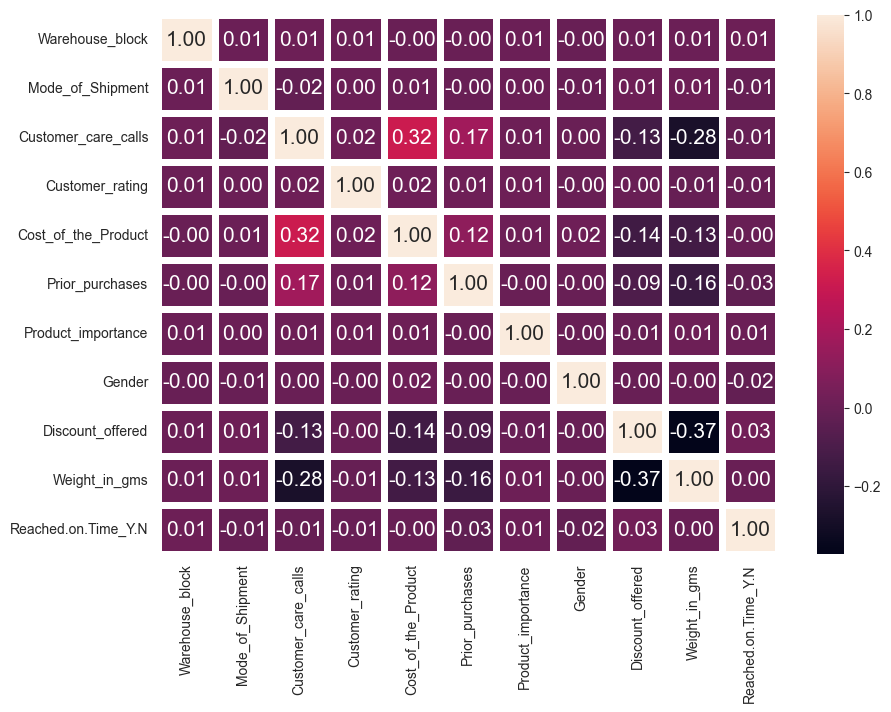

In [209]:
# label encoder로 변환 뒤 히트맵 그리기
from sklearn.preprocessing import LabelEncoder

data = train_df.copy()
data.drop(columns = ['ID','Reached.on.Time_Y.N'], inplace = True)
data['Reached.on.Time_Y.N'] = test_df['Reached.on.Time_Y.N']

object_cols = data.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in object_cols:
    data[col] = le.fit_transform(data[col])

plt.figure(figsize = (10, 7))
sns.heatmap(data.corr(numeric_only=True), annot = True, fmt = '0.2f', annot_kws = {'size' : 15}, linewidth = 5, linecolor = 'white')
plt.show()

In [ ]:
def experimental_feature_engineering(df):
   # 배송부담지수: 운송 수단별 평균 무게 대비 해당 화물의 무게 비중
   # df['Shipping_Burden'] = df['Weight_in_gms'] / df.groupby('Mode_of_Shipment')['Weight_in_gms'].transform('mean')

   # 고위험품목: 고가이면서 무거운 제품
   # df['Is_High_Risk'] = ((df['Cost_of_the_Product'] > df['Cost_of_the_Product'].median()) & (df['Weight_in_gms'] > df['Weight_in_gms'].median())).astype(int)
  
   # 창고별 처리 물량: 병목현상으로 인한 지연 위험
   df['Warehouse_Load'] = df.groupby('Warehouse_block')['Warehouse_block'].transform('count')

   # 상담 빈도 압박: 이전 구매 횟수 대비 상담 전화 빈도
   df['Care_Pressure'] = df['Customer_care_calls'] / (df['Prior_purchases'] + 1)

   # 고객 우선순위 지수
   df['Priority_Score'] = df['Product_importance']/ (df['Customer_rating'] + 1)

   # 단골 고객 여부
   # df['Is_Loyal_Customer'] = (df['Prior_purchases'] >= df['Prior_purchases'].median()).astype(int)

   # 예상 배송 민감도
   df['Expectation_Gap'] = df['Cost_of_the_Product'] * df['Discount_offered']


   return df


In [211]:
experimental_feature_engineering(data)

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Shipping_Burden,Is_High_Risk,Warehouse_Load,Care_Pressure,Priority_Score,Is_Loyal_Customer,Expectation_Gap
0,3,1,4,1,261,2,2,0,9,4158,1.0,1.145192,1,1470,1.333333,1.000000,0,2349
1,4,2,3,3,162,2,1,0,26,1659,1.0,0.455873,0,2910,1.000000,0.250000,0,4212
2,1,2,3,2,221,2,2,1,9,4466,0.0,1.227203,1,1487,1.000000,0.666667,0,1989
3,3,2,3,5,157,4,2,0,2,4640,0.0,1.275017,0,1470,0.600000,0.333333,1,314
4,0,0,2,5,272,2,1,1,24,3638,0.0,1.011069,0,1468,0.666667,0.166667,0,6528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8794,1,1,4,4,204,3,1,0,9,4757,NaN,1.310168,0,1487,1.000000,0.200000,1,1836
8795,2,2,4,2,237,3,1,0,7,4785,NaN,1.314861,1,1464,1.000000,0.333333,1,1659
8796,3,0,4,1,140,4,1,1,6,5067,NaN,1.408216,0,1470,0.800000,0.500000,1,840
8797,1,2,4,4,251,2,2,0,6,4376,NaN,1.202472,1,1487,1.333333,0.400000,0,1506


In [212]:
data.corr()['Reached.on.Time_Y.N']

Warehouse_block        0.008894
Mode_of_Shipment      -0.011230
Customer_care_calls   -0.008882
Customer_rating       -0.006769
Cost_of_the_Product   -0.003803
Prior_purchases       -0.032513
Product_importance     0.005719
Gender                -0.019580
Discount_offered       0.026623
Weight_in_gms          0.002472
Reached.on.Time_Y.N    1.000000
Shipping_Burden        0.002539
Is_High_Risk           0.015971
Warehouse_Load         0.016001
Care_Pressure          0.016031
Priority_Score         0.008412
Is_Loyal_Customer      0.002516
Expectation_Gap        0.021182
Name: Reached.on.Time_Y.N, dtype: float64

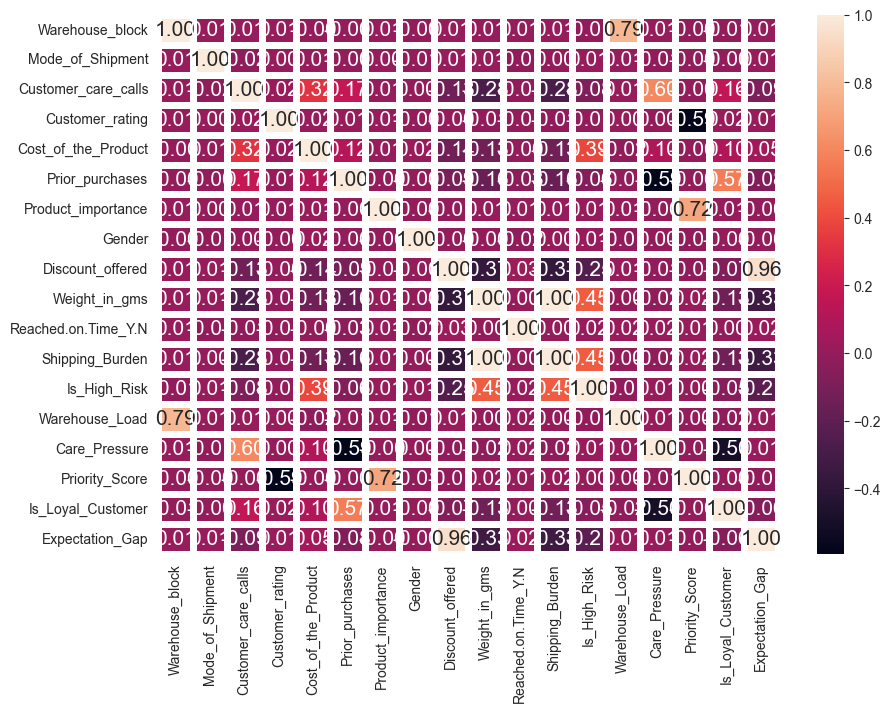

In [213]:
plt.figure(figsize = (10, 7))
sns.heatmap(data.corr(numeric_only=True), annot = True, fmt = '0.2f', annot_kws = {'size' : 15}, linewidth = 5, linecolor = 'white')
plt.show()

In [214]:
# 원본에 없던 새로운 컬럼들만 리스트로 출력
new_columns = list(set(data.columns) - set(train_df.columns))
print(f"새로 생성된 변수 ({len(new_columns)}개):", new_columns)

# 새로 만든 변수들과 타겟 변수만 따로 모아서 확인
new_data_subset = data[new_columns + ['Reached.on.Time_Y.N']]
print(new_data_subset.head())



새로 생성된 변수 (7개): ['Is_High_Risk', 'Care_Pressure', 'Warehouse_Load', 'Priority_Score', 'Shipping_Burden', 'Expectation_Gap', 'Is_Loyal_Customer']
   Is_High_Risk  Care_Pressure  Warehouse_Load  Priority_Score  \
0             1       1.333333            1470        1.000000   
1             0       1.000000            2910        0.250000   
2             1       1.000000            1487        0.666667   
3             0       0.600000            1470        0.333333   
4             0       0.666667            1468        0.166667   

   Shipping_Burden  Expectation_Gap  Is_Loyal_Customer  Reached.on.Time_Y.N  
0         1.145192             2349                  0                  1.0  
1         0.455873             4212                  0                  1.0  
2         1.227203             1989                  0                  0.0  
3         1.275017              314                  1                  0.0  
4         1.011069             6528                  0              

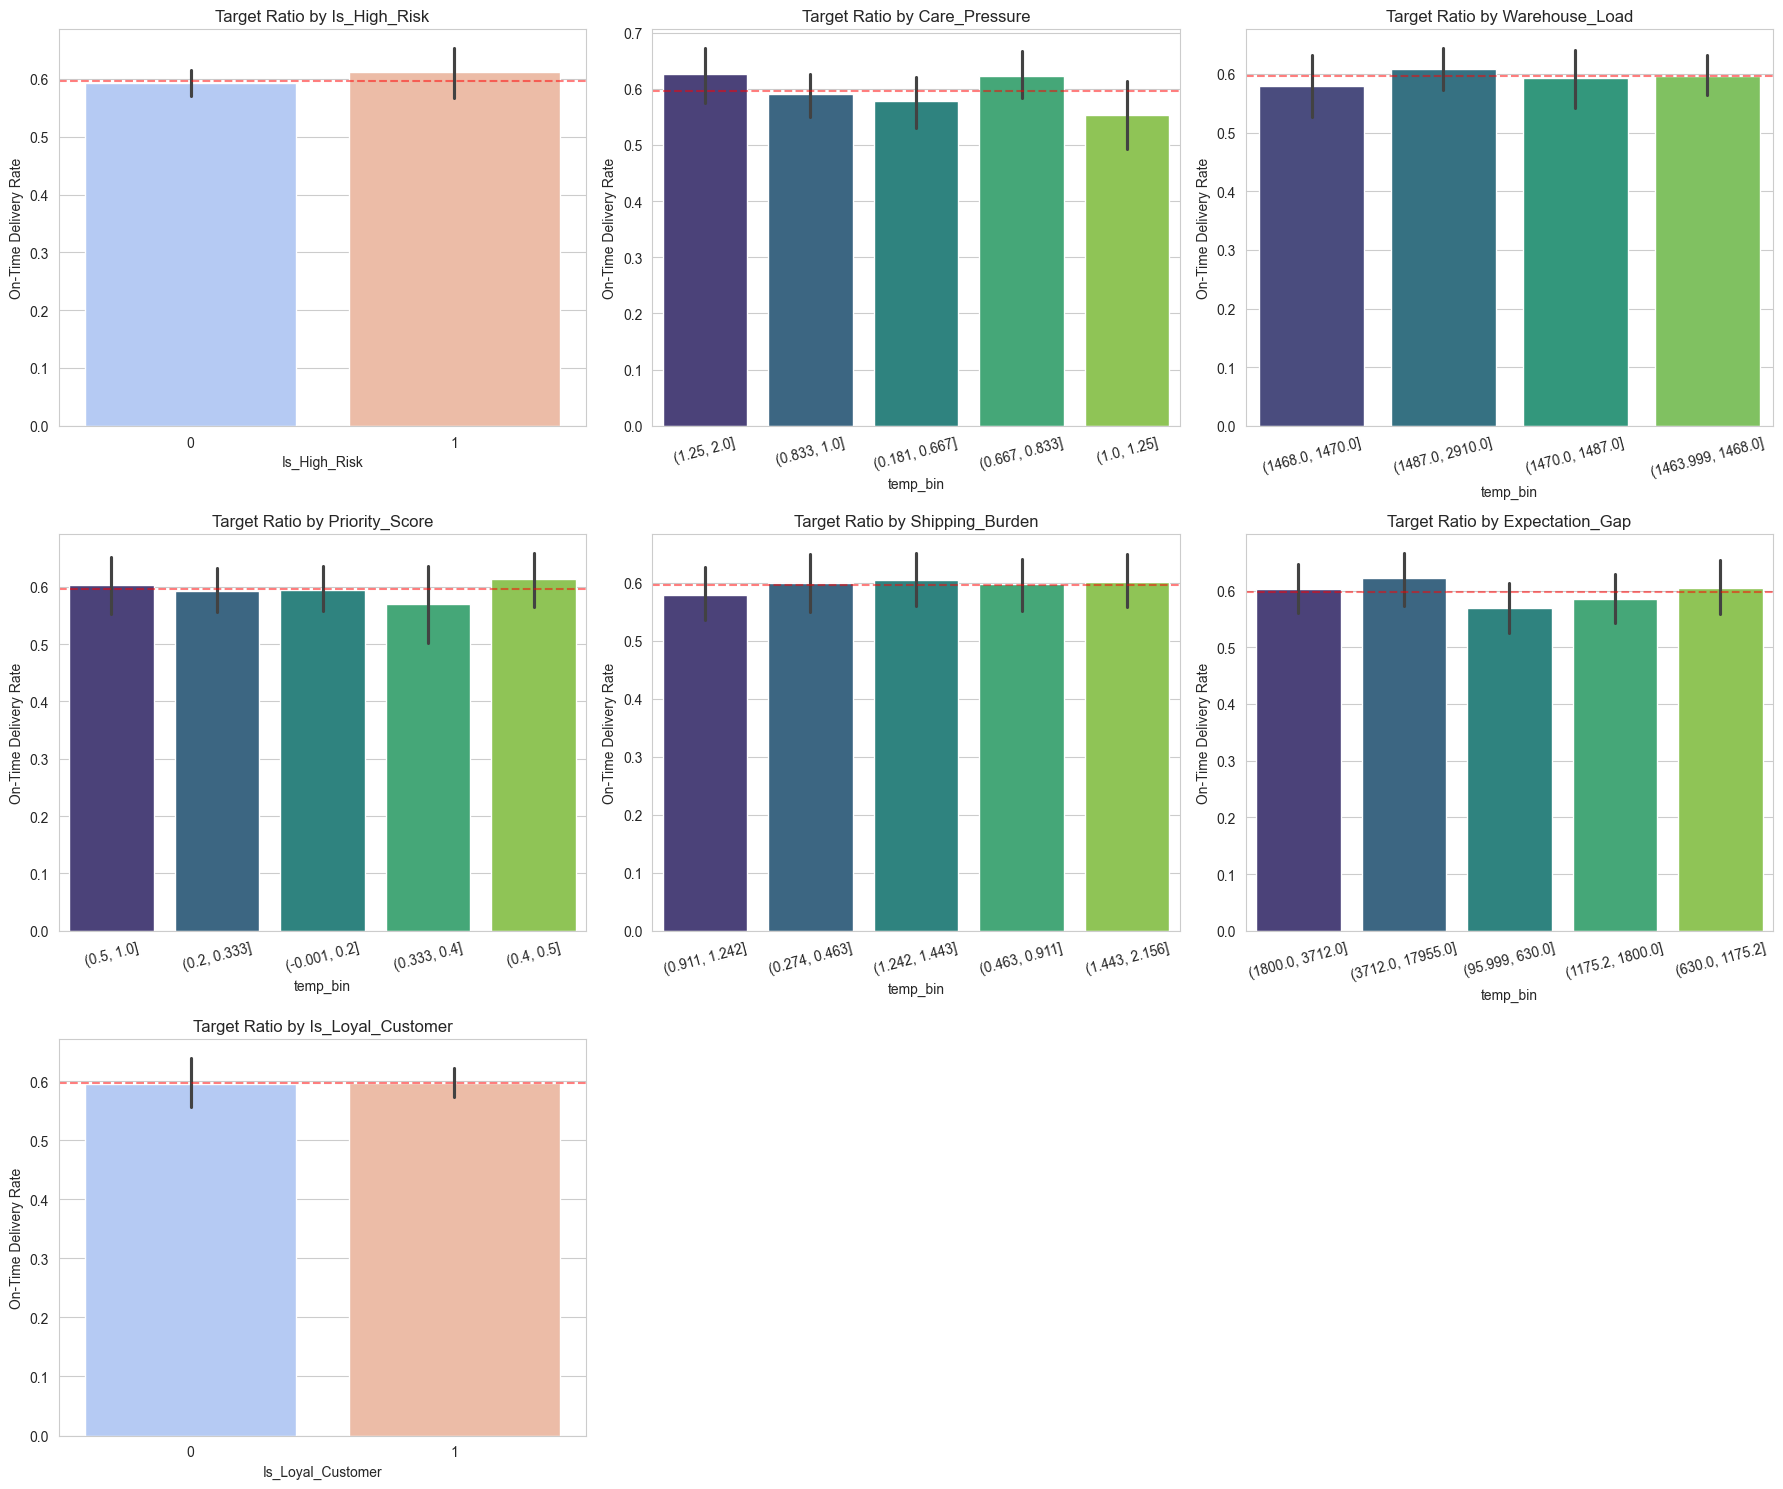

In [215]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# 시각화할 컬럼 리스트 (new_columns 중 수치형 변수만 필터링)
# 만약 결측치가 있다면 fillna(0) 등으로 처리 후 진행하세요.
plot_cols = [c for c in new_columns if data[c].nunique() > 2] # 연속형
binary_cols = [c for c in new_columns if data[c].nunique() <= 2] # 이진형

# 그래프 배치 설정 (한 줄에 3개씩)
n_cols = 3
n_rows = math.ceil(len(new_columns) / n_cols)

plt.figure(figsize=(18, n_rows * 5))

for i, col in enumerate(new_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    
    if col in binary_cols:
        # 이진 변수 (0, 1)는 그대로 평균값 시각화
        sns.barplot(x=col, y='Reached.on.Time_Y.N', data=data, palette='coolwarm',hue=col, legend=False)
    else:
        # 연속형 변수는 5개 구간으로 나누어 시각화 (qcut 사용)
        try:
            data['temp_bin'] = pd.qcut(data[col], q=5, duplicates='drop').astype(str)
            sns.barplot(x='temp_bin', y='Reached.on.Time_Y.N', data=data, palette='viridis',hue='temp_bin', legend=False)
            plt.xticks(rotation=15)
        except:
            # 구간화가 불가능할 정도로 값이 중복되면 그냥 선 그래프
            sns.lineplot(x=col, y='Reached.on.Time_Y.N', data=data)

    plt.title(f'Target Ratio by {col}', fontsize=12)
    plt.ylabel('On-Time Delivery Rate')
    plt.axhline(data['Reached.on.Time_Y.N'].mean(), color='red', linestyle='--', alpha=0.5) # 전체 평균선

plt.tight_layout()
plt.show()

### Feature engineering

In [328]:
train_df = pd.read_csv('data/train_df.csv')
test_df = pd.read_csv('data/test_df.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8799 entries, 0 to 8798
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   8799 non-null   int64 
 1   Warehouse_block      8799 non-null   object
 2   Mode_of_Shipment     8799 non-null   object
 3   Customer_care_calls  8799 non-null   int64 
 4   Customer_rating      8799 non-null   int64 
 5   Cost_of_the_Product  8799 non-null   int64 
 6   Prior_purchases      8799 non-null   int64 
 7   Product_importance   8799 non-null   object
 8   Gender               8799 non-null   object
 9   Discount_offered     8799 non-null   int64 
 10  Weight_in_gms        8799 non-null   int64 
 11  Reached.on.Time_Y.N  8799 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 825.0+ KB


In [329]:
def apply_feature_engineering(df):
    # 1. Discount_Group 생성
    df['Discount_Group'] = (df['Discount_offered'] > 10).astype(int)
    
    # 2. Weight_Category 생성
    bins = [0, 2000, 4000, float('inf')]
    labels = ['light', 'medium', 'heavy']
    # 'Weight_Category' 생성 후 바로 숫자로 인코딩 (Ordinal)
    df['Weight_Category'] = pd.cut(df['Weight_in_gms'], bins=bins, labels=labels)
    # 모델 입력을 위해 숫자로 변환 (light:0, medium:1, heavy:2)
    df['Weight_Category'] = df['Weight_Category'].map({'light': 0, 'medium': 1, 'heavy': 2}).astype(int)
    
    # 3. log_rel_price 생성
    # 무게가 0인 경우를 대비해 아주 작은 값을 더하거나 예외처리 (이 데이터셋은 보통 양수임)
    df['log_rel_price'] = np.log(df['Cost_of_the_Product'] / df['Weight_in_gms'])
    
    # 4. Product_importance: Label Encoding (순서가 있으므로 수동 매핑)
    importance_map = {'low': 0, 'medium': 1, 'high': 2}
    df['Product_importance'] = df['Product_importance'].map(importance_map)

    # 5. prior purchase 6이상 묶기
    df['Prior_purchases'] = df['Prior_purchases'].clip(upper=6)

    #  창고별 처리 물량: 병목현상으로 인한 지연 위험
    df['Warehouse_Load'] = df.groupby('Warehouse_block')['Warehouse_block'].transform('count')

    # 상담 빈도 압박: 이전 구매 횟수 대비 상담 전화 빈도
    df['Care_Pressure'] = df['Customer_care_calls'] / (df['Prior_purchases'] + 1)

    # 고객 우선순위 지수
    df['Priority_Score'] = df['Product_importance']/ (df['Customer_rating'] + 1)

    # 예상 배송 민감도
    df['Expectation_Gap'] = df['Cost_of_the_Product'] * df['Discount_offered']

    # 배송부담지수: 운송 수단별 평균 무게 대비 해당 화물의 무게 비중
    df['Shipping_Burden'] = df['Weight_in_gms'] / df.groupby('Mode_of_Shipment')['Weight_in_gms'].transform('mean')

    # 고위험품목: 고가이면서 무거운 제품
    # df['Is_High_Risk'] = ((df['Cost_of_the_Product'] > df['Cost_of_the_Product'].median()) & (df['Weight_in_gms'] > df['Weight_in_gms'].median())).astype(int)
   
    # 1. 창고별 배송수단 조합 (예: 'A_Flight', 'F_Ship')
    # 단순 결합만으로도 특정 창고+수단 조합의 지연 패턴을 포착할 수 있습니다.
    df['Wh_Shipment_Combo'] = df['Warehouse_block'].astype(str) + '_' + df['Mode_of_Shipment'].astype(str)
    
    # 모델 학습을 위해 범주형을 숫자로 매핑 (Label Encoding과 유사)
    # AutoGluon을 쓰신다면 문자열 그대로 두어도 되지만, Scikit-learn 모델을 위해 숫자로 변환합니다.
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    df['Wh_Shipment_Combo'] = le.fit_transform(df['Wh_Shipment_Combo']) + 1

    return df

# 각각의 데이터셋에 적용
train_df = apply_feature_engineering(train_df)
test_df = apply_feature_engineering(test_df)


In [330]:
# train_df = experimental_feature_engineering(train_df)
# test_df = experimental_feature_engineering(test_df)

In [331]:
drop_columns = ["ID", "Gender", "Discount_offered", "Weight_in_gms",'Warehouse_block' ]
train_df = train_df.drop(drop_columns, axis=1)
test_df = test_df.drop(drop_columns, axis=1)

In [332]:
from sklearn.preprocessing import StandardScaler

# 1. One-Hot Encoding (Warehouse_block, Mode_of_Shipment)
# drop_first=True를 통해 다중공선성을 방지합니다.
train_df = pd.get_dummies(train_df, columns=['Mode_of_Shipment'])
test_df = pd.get_dummies(test_df, columns=['Mode_of_Shipment'])

# 2. Scaling 대상 컬럼 선정
# 새로 만든 log_rel_price와 기존 수치형 변수들을 포함합니다.
scale_cols = train_df.select_dtypes(include=['number']).columns.drop('Reached.on.Time_Y.N').tolist()

scaler = StandardScaler()

# 중요: fit은 오직 train_df에만 수행합니다!
train_df[scale_cols] = scaler.fit_transform(train_df[scale_cols])

# test와 eval은 transform만 수행하여 데이터 누수를 차단합니다.
test_df[scale_cols] = scaler.transform(test_df[scale_cols])

In [333]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Customer_care_calls      2200 non-null   float64
 1   Customer_rating          2200 non-null   float64
 2   Cost_of_the_Product      2200 non-null   float64
 3   Prior_purchases          2200 non-null   float64
 4   Product_importance       2200 non-null   float64
 5   Reached.on.Time_Y.N      2200 non-null   int64  
 6   Discount_Group           2200 non-null   float64
 7   Weight_Category          2200 non-null   float64
 8   log_rel_price            2200 non-null   float64
 9   Warehouse_Load           2200 non-null   float64
 10  Care_Pressure            2200 non-null   float64
 11  Priority_Score           2200 non-null   float64
 12  Expectation_Gap          2200 non-null   float64
 13  Shipping_Burden          2200 non-null   float64
 14  Wh_Shipment_Combo       

In [303]:
import random
from autogluon.tabular import TabularPredictor

# 기본 단위: 초(sec)
setTime= 10 * 60

# 파이썬 및 넘파이 시드 고정
random.seed(42)
np.random.seed(42)

# AutoGluon 모델 학습
predictor = TabularPredictor(
    label='Reached.on.Time_Y.N',
    problem_type='binary',
    eval_metric='accuracy',
    path='./autogluon_models'
)

# 모델 학습 (다양한 모델 앙상블)
predictor.fit(
    train_data=train_df,
    time_limit=setTime,  # 10분
    presets='medium_quality',  # 최고 품질 설정
    num_bag_folds=5,
    num_stack_levels=1,
    verbosity=2,

)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.11.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Pytorch Version:    2.6.0+cu124
CUDA Version:       12.4
GPU Memory:         GPU 0: 11.99/11.99 GB
Total GPU Memory:   Free: 11.99 GB, Allocated: 0.00 GB, Total: 11.99 GB
GPU Count:          1
Memory Avail:       9.68 GB / 31.74 GB (30.5%)
Disk Space Avail:   390.14 GB / 930.67 GB (41.9%)
Presets specified: ['medium_quality']
Using hyperparameters preset: hyperparameters='default'
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "c:\Users\ysj58\github\DataScience\scikit-learn\E-commerce\autogluon_models"
Train Data Rows:    8799
Train Data Columns: 17
Label Column:       Reached.on.Time_Y.N
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature

In [304]:
# 학습된 모델 요약
print('=== 학습된 모델 리더보드 ===')
leaderboard = predictor.leaderboard(train_df, silent=True)
print(leaderboard)

=== 학습된 모델 리더보드 ===
                      model  score_test  score_val eval_metric  \
0   RandomForestEntr_BAG_L1    1.000000   0.659961    accuracy   
1   RandomForestGini_BAG_L1    1.000000   0.664735    accuracy   
2     ExtraTreesEntr_BAG_L1    1.000000   0.661893    accuracy   
3     ExtraTreesGini_BAG_L1    1.000000   0.661212    accuracy   
4      LightGBMLarge_BAG_L1    0.979543   0.671440    accuracy   
5           LightGBM_BAG_L1    0.798613   0.682123    accuracy   
6           CatBoost_BAG_L2    0.751790   0.692920    accuracy   
7            XGBoost_BAG_L1    0.744062   0.681896    accuracy   
8         LightGBMXT_BAG_L1    0.743607   0.684510    accuracy   
9     NeuralNetTorch_BAG_L2    0.729628   0.689283    accuracy   
10   NeuralNetFastAI_BAG_L2    0.710308   0.688715    accuracy   
11   NeuralNetFastAI_BAG_L1    0.702807   0.683941    accuracy   
12        LightGBMXT_BAG_L2    0.697579   0.692920    accuracy   
13    NeuralNetTorch_BAG_L1    0.697238   0.686555    ac

In [305]:
# test_df를 이용한 최종 Accuracy 측정
# 가장 우수한 성능을 보인 베스트 모델로 자동 평가합니다.
performance = predictor.evaluate(test_df)
print(f"\n최종 Test Accuracy: {performance['accuracy']:.4f}")


최종 Test Accuracy: 0.6759


Computing feature importance via permutation shuffling for 17 features using 5000 rows with 5 shuffle sets...


=== 특성 중요도 ===


	158.84s	= Expected runtime (31.77s per shuffle set)
	45.96s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Weight_Category,0.03448,0.006220,0.000122,5,0.047288,0.021672
Discount_Group,0.02236,0.002410,0.000016,5,0.027322,0.017398
Product_importance,0.01660,0.001543,0.000009,5,0.019776,0.013424
Customer_rating,0.01304,0.000805,0.000002,5,0.014697,0.011383
Customer_care_calls,0.01296,0.002364,0.000127,5,0.017827,0.008093
Prior_purchases,0.01044,0.002751,0.000529,5,0.016104,0.004776
Warehouse_Load,0.00940,0.002421,0.000484,5,0.014384,0.004416
Mode_of_Shipment_Ship,0.00836,0.002017,0.000377,5,0.012513,0.004207
Mode_of_Shipment_Road,0.00772,0.001932,0.000434,5,0.011698,0.003742
Mode_of_Shipment_Flight,0.00748,0.000901,0.000025,5,0.009335,0.005625


C:\Users\ysj58\AppData\Local\Temp\ipykernel_8332\1392949763.py:14: UserWarning:

Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) Arial.

C:\Users\ysj58\AppData\Local\Temp\ipykernel_8332\1392949763.py:14: UserWarning:

Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) Arial.

C:\Users\ysj58\AppData\Local\Temp\ipykernel_8332\1392949763.py:14: UserWarning:

Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) Arial.

C:\Users\ysj58\AppData\Local\Temp\ipykernel_8332\1392949763.py:14: UserWarning:

Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from font(s) Arial.

C:\Users\ysj58\AppData\Local\Temp\ipykernel_8332\1392949763.py:14: UserWarning:

Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) Arial.

C:\Users\ysj58\AppData\Local\Temp\ipykernel_8332\1392949763.py:14: UserWarning:

Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) Arial.

C:\Users\ysj58\AppData\Local\Temp\ipykernel_8332\1392949763.py:14: UserWarning:

Glyph 50948 (\N{HANGUL SYLLA

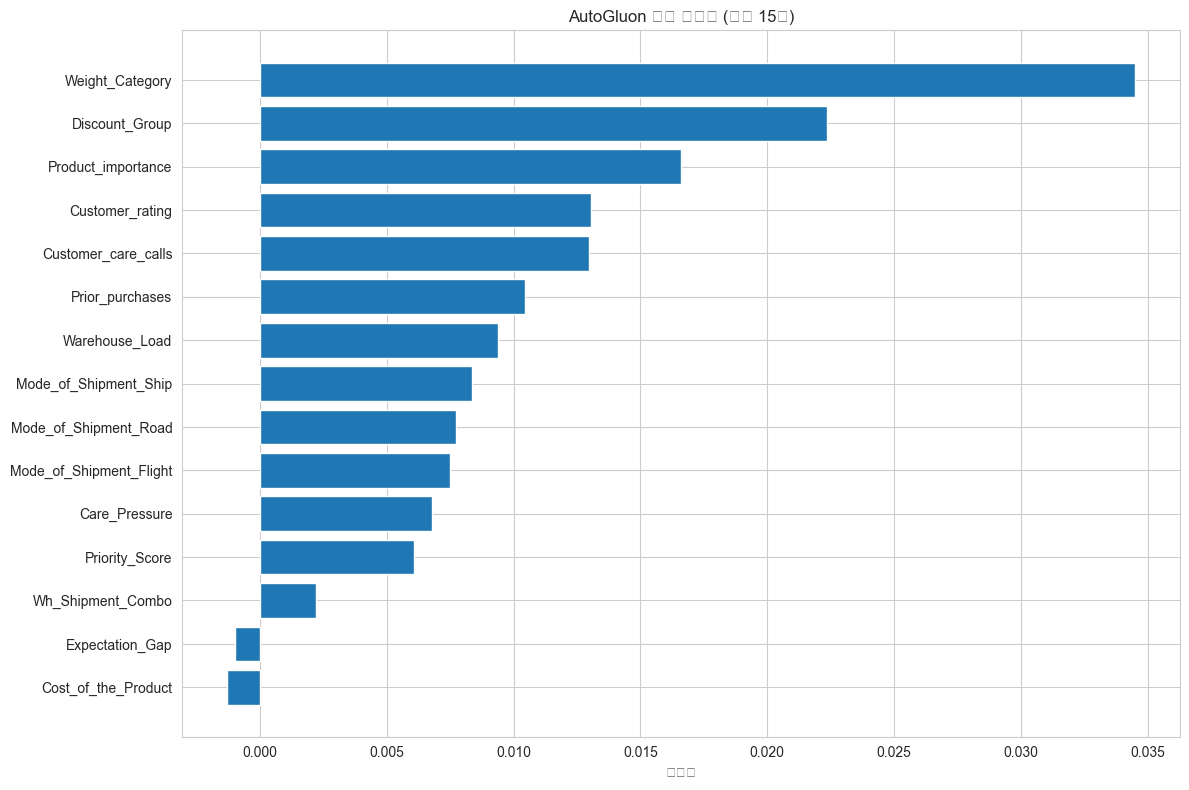

In [306]:
# 특성 중요도
print('=== 특성 중요도 ===')
feature_importance = predictor.feature_importance(train_df)
display(feature_importance.head(20))

# 특성 중요도 시각화
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('중요도')
plt.title('AutoGluon 특성 중요도 (상위 15개)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 모델 생성


In [334]:
# train_df를 X_train, y_train, X_test, y_test으로 분리

label = 'Reached.on.Time_Y.N'
X = train_df.drop(label, axis=1)
y = train_df[label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [335]:
train_df.shape

(8799, 18)

In [336]:
X_train.shape

(7039, 17)

Training Logistic Regression...
Training Random Forest...
Training XGBoost...
Training SVM...

=== 모델 성능 비교 ===
                 Model  Accuracy  F1-Score       AUC
3                  SVM  0.678977  0.650155  0.738338
1        Random Forest  0.666477  0.689254  0.741753
0  Logistic Regression  0.661364  0.664036  0.731622
2              XGBoost  0.647159  0.685251  0.722064


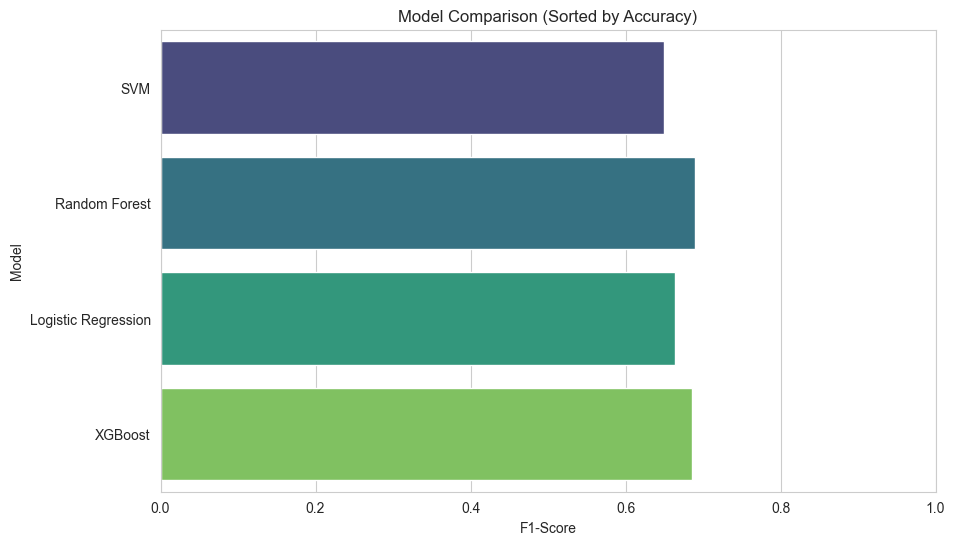

In [337]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델 라이브러리 임포트
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


# 테스트할 모델 리스트 정의
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42,),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "SVM": SVC(probability=True, random_state=42) # 확률 계산을 위해 probability=True 필요
}

# 모델 학습 및 평가 루프
results = []

for name, model in models.items():
    print(f"Training {name}...")
    
    # 학습
    model.fit(X_train, y_train)
    
    # 예측
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:, 1] # AUC 계산용 확률값
    
    # 평가 지표 계산
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba)
    
    results.append([name, acc, f1, auc])

# 4. 결과 정리 및 시각화
result_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1-Score", "AUC"])
result_df = result_df.sort_values(by="Accuracy", ascending=False) 


print("\n=== 모델 성능 비교 ===")
print(result_df)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x="F1-Score", y="Model", data=result_df, hue='Model', palette="viridis", legend=False)
plt.title("Model Comparison (Sorted by Accuracy)")
plt.xlim(0, 1)
plt.show()

In [338]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# 2. 성능 지표 계산 및 추가 함수 (반복 작업을 줄이기 위함)
def add_model_result(model_name, y_test, y_pred, y_prob):
    global result_df
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) # 확률값을 사용해야 AUC가 정확합니다.
    
    # 새로운 행 생성 후 데이터프레임에 결합
    new_result = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [acc],
        'F1-Score': [f1],
        'AUC': [auc]
    })
    
    result_df = pd.concat([result_df, new_result], ignore_index=True)

# --- 사용 예시 (변수명은 환경에 맞게 수정하세요) ---
# add_model_result('RandomForest', y_test, rf_pred, rf_prob)
# add_model_result('XGBoost', y_test, xgb_pred, xgb_prob)

# 3. Accuracy 기준으로 내림차순 정렬
result_df = result_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# 결과 확인
print(result_df)

                 Model  Accuracy  F1-Score       AUC
0                  SVM  0.678977  0.650155  0.738338
1        Random Forest  0.666477  0.689254  0.741753
2  Logistic Regression  0.661364  0.664036  0.731622
3              XGBoost  0.647159  0.685251  0.722064


In [339]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

def objective(trial):
    # 1. Suggest which model to use
    classifier_name = trial.suggest_categorical("classifier", ["Logistic Regression", "Random Forest", "XGBoost", "SVM"])
    
    # 2. Define search spaces for each model
    if classifier_name == "Logistic Regression":
        c = trial.suggest_float("lr_c", 1e-4, 100, log=True)
        model = LogisticRegression(C=c, solver='liblinear', random_state=42)
        
    elif classifier_name == "Random Forest":
        n_estimators = trial.suggest_int("rf_n_estimators", 100, 1000)
        max_depth = trial.suggest_int("rf_max_depth", 3, 15)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        
    elif classifier_name == "XGBoost":
        param = {
            'n_estimators': trial.suggest_int('xgb_n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('xgb_max_depth', 3, 8),
            'learning_rate': trial.suggest_float('xgb_lr', 0.01, 0.2, log=True),
            'subsample': trial.suggest_float('xgb_subsample', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('xgb_min_child', 1, 10),
            'random_state': 42,
            'eval_metric': 'logloss'
        }
        model = XGBClassifier(**param)
        
    else: # SVM
        c = trial.suggest_float("svc_c", 1e-4, 100, log=True)
        gamma = trial.suggest_float("svc_gamma", 1e-4, 1, log=True)
        model = SVC(C=c, gamma=gamma, probability=True, random_state=42)

    # 3. Cross-Validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
    
    return score.mean()

# 4. Run the Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1) # Increased trials since we have 4 models to test





[I 2026-02-03 16:26:15,583] A new study created in memory with name: no-name-c8cfb79b-3359-46e5-9a9d-c0e6e4d35b7d
[I 2026-02-03 16:26:26,411] Trial 2 finished with value: 0.6924101049065767 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 432, 'xgb_max_depth': 4, 'xgb_lr': 0.05955289665241211, 'xgb_subsample': 0.8042371579032949, 'xgb_min_child': 10}. Best is trial 2 with value: 0.6924101049065767.
[I 2026-02-03 16:26:26,675] Trial 1 finished with value: 0.6760372118173809 and parameters: {'classifier': 'Logistic Regression', 'lr_c': 0.0239788502947937}. Best is trial 2 with value: 0.6924101049065767.
[I 2026-02-03 16:26:26,896] Trial 3 finished with value: 0.6777984908952566 and parameters: {'classifier': 'Logistic Regression', 'lr_c': 91.18987361918151}. Best is trial 2 with value: 0.6924101049065767.
[I 2026-02-03 16:26:26,970] Trial 4 finished with value: 0.6756433700440443 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 665, 'xgb_max_depth': 6, 'xgb_lr':

In [340]:
# 1. 최적 결과 확인
print("Best trial score:", study.best_value)
print("Best params:", study.best_params)

Best trial score: 0.7473974789636479
Best params: {'classifier': 'SVM', 'svc_c': 0.02133985940576937, 'svc_gamma': 0.8080487495868623}


In [341]:
# 2. 최적 파라미터로 모델 재정의 및 학습
# Optuna가 찾은 'classifier' 이름에 따라 모델 객체를 다시 만듭니다.
best_params = study.best_params.copy()
classifier_name = best_params.pop('classifier')

# 각 모델별로 저장된 파라미터 접두사(lr_, rf_, xgb_, svc_)를 제거하고 모델 생성
if classifier_name == "Logistic Regression":
    model = LogisticRegression(C=best_params['lr_c'], solver='liblinear', random_state=42)
elif classifier_name == "Random Forest":
    model = RandomForestClassifier(n_estimators=best_params['rf_n_estimators'], 
                                   max_depth=best_params['rf_max_depth'], random_state=42)
elif classifier_name == "XGBoost":
    model = XGBClassifier(n_estimators=best_params['xgb_n_estimators'],
                          max_depth=best_params['xgb_max_depth'],
                          learning_rate=best_params['xgb_lr'],
                          subsample=best_params['xgb_subsample'],
                          min_child_weight=best_params['xgb_min_child'],
                          random_state=42, eval_metric='logloss')
else: # SVM
    model = SVC(C=best_params['svc_c'], gamma=best_params['svc_gamma'], probability=True, random_state=42)

# 3. 전체 학습 데이터로 최종 학습 (중요!)
model.fit(X_train, y_train)



,C,0.02133985940576937
,kernel,'rbf'
,degree,3
,gamma,0.8080487495868623
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [342]:
# 4. 성능 지표 계산
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

# 5. result_df에 추가 및 정렬
new_row = pd.DataFrame({
    'Model': [f"Tuned_{classifier_name}"],
    'Accuracy': [acc],
    'F1-Score': [f1],
    'AUC': [auc]
})

# 기존에 result_df가 정의되어 있어야 합니다.
result_df = pd.concat([result_df, new_row], ignore_index=True)
result_df = result_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print(result_df)

                 Model  Accuracy  F1-Score       AUC
0                  SVM  0.678977  0.650155  0.738338
1        Random Forest  0.666477  0.689254  0.741753
2  Logistic Regression  0.661364  0.664036  0.731622
3              XGBoost  0.647159  0.685251  0.722064
4            Tuned_SVM  0.596591  0.747331  0.733556


In [343]:
# 6. 앙상블을 위한 모델별 최적 하이퍼파라미터 추출 함수
def get_best_model_params(model_name):
    # 해당 모델에서 가장 성적이 좋았던 trial 선택
    model_trial = df_results[df_results['params_classifier'] == model_name].sort_values('value', ascending=False).iloc[0]
    # 'params_' 접두사를 제거하고 딕셔너리로 변환
    params = {k.replace('params_', ''): v for k, v in model_trial.items() 
              if k.startswith('params_') and pd.notna(v) and k != 'params_classifier'}
    return params


In [344]:
from sklearn.ensemble import VotingClassifier

# 7. 개별 최적 모델 객체 생성
# (int형 파라미터는 trial 기록 시 float으로 저장될 수 있어 int() 처리가 안전합니다)
lr_p = get_best_model_params("Logistic Regression")
best_lr = LogisticRegression(C=lr_p['lr_c'], solver='liblinear', random_state=42)

rf_p = get_best_model_params("Random Forest")
best_rf = RandomForestClassifier(n_estimators=int(rf_p['rf_n_estimators']), max_depth=int(rf_p['rf_max_depth']), random_state=42)

xgb_p = get_best_model_params("XGBoost")
best_xgb = XGBClassifier(
    n_estimators=int(xgb_p['xgb_n_estimators']), max_depth=int(xgb_p['xgb_max_depth']),
    learning_rate=xgb_p['xgb_lr'], subsample=xgb_p['xgb_subsample'],
    min_child_weight=int(xgb_p['xgb_min_child']), random_state=42, eval_metric='logloss'
)

svc_p = get_best_model_params("SVM")
best_svc = SVC(C=svc_p['svc_c'], gamma=svc_p['svc_gamma'], probability=True, random_state=42)

# 8. Soft Voting Ensemble 모델 구성 및 학습
vote_ensemble = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('svc', best_svc)
    ],
    voting='soft' # 확률 기반 투표
)

vote_ensemble.fit(X_train, y_train)



,estimators,"[('lr', ...), ('rf', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,np.float64(0....1631911587608)
,fit_intercept,True


In [345]:
# 9. 앙상블 성능 확인

y_pred_vote = vote_ensemble.predict(X_test)
y_prob_vote = vote_ensemble.predict_proba(X_test)[:, 1]

# 미리 정의한 add_model_result 함수 호출
add_model_result('Tuned_Voting_Ensemble', y_test, y_pred_vote, y_prob_vote)

# Accuracy 기준으로 다시 정렬 (함수 밖에 있다면 한 번 더 실행)
result_df = result_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# 최종 결과 확인
print(result_df)

                   Model  Accuracy  F1-Score       AUC
0                    SVM  0.678977  0.650155  0.738338
1  Tuned_Voting_Ensemble  0.670455  0.684096  0.734027
2          Random Forest  0.666477  0.689254  0.741753
3    Logistic Regression  0.661364  0.664036  0.731622
4                XGBoost  0.647159  0.685251  0.722064
5              Tuned_SVM  0.596591  0.747331  0.733556


In [346]:
from sklearn.ensemble import StackingClassifier

# 1. Stacking에 사용할 개별 모델 리스트 (Base Learners)
# 앞서 정의한 best_lr, best_rf, best_xgb, best_svc를 그대로 사용합니다.
base_models = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('svc', best_svc)
]

# 2. 최종 결합 모델 정의 (Meta Learner)
# 개별 모델들의 예측 결과를 받아서 최종 판단을 내리는 모델입니다.
final_model = LogisticRegression()

# 3. Stacking Classifier 구성
stacking_lr = StackingClassifier(
    estimators=base_models,
    final_estimator=final_model,
    cv=5,            # 각 모델의 예측값을 만들 때 사용할 내부 교차 검증 분할 수
    stack_method='predict_proba', # 확률값을 메타 특성으로 사용 (성능에 유리)
    n_jobs=-1
)



In [347]:
# 4. 모델 학습 및 평가
# Stacking 모델 학습 (데이터 양에 따라 시간이 조금 걸릴 수 있습니다)
stacking_lr.fit(X_train, y_train)

# 테스트 데이터로 예측 및 확률 계산
y_pred_stack = stacking_lr.predict(X_test)
y_prob_stack = stacking_lr.predict_proba(X_test)[:, 1]

# 이전에 정의한 함수를 호출하여 result_df에 추가
add_model_result('Tuned_Stacking_LR', y_test, y_pred_stack, y_prob_stack)

# Accuracy 기준으로 내림차순 정렬
result_df = result_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# 최종 결과 확인
print(result_df)

                   Model  Accuracy  F1-Score       AUC
0                    SVM  0.678977  0.650155  0.738338
1      Tuned_Stacking_LR  0.674432  0.656269  0.731890
2  Tuned_Voting_Ensemble  0.670455  0.684096  0.734027
3          Random Forest  0.666477  0.689254  0.741753
4    Logistic Regression  0.661364  0.664036  0.731622
5                XGBoost  0.647159  0.685251  0.722064
6              Tuned_SVM  0.596591  0.747331  0.733556


In [348]:
from sklearn.ensemble import StackingClassifier

# 1. Stacking에 사용할 개별 모델 리스트 (Base Learners)
# 앞서 정의한 best_lr, best_rf, best_xgb, best_svc를 그대로 사용합니다.
base_models = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('svc', best_svc)
]

# 2. 최종 결합 모델 정의 (Meta Learner)
# 개별 모델들의 예측 결과를 받아서 최종 판단을 내리는 모델입니다.
final_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# 3. Stacking Classifier 구성
stacking_rf = StackingClassifier(
    estimators=base_models,
    final_estimator=final_model,
    cv=5,            # 각 모델의 예측값을 만들 때 사용할 내부 교차 검증 분할 수
    stack_method='predict_proba', # 확률값을 메타 특성으로 사용 (성능에 유리)
    n_jobs=-1
)



In [349]:
# 4. 모델 학습 및 평가
# Stacking 모델 학습
stacking_rf.fit(X_train, y_train)

# 테스트 데이터로 예측 및 확률 추출
y_pred_stack_rf = stacking_rf.predict(X_test)
y_prob_stack_rf = stacking_rf.predict_proba(X_test)[:, 1]

# 함수를 사용하여 result_df에 추가 (구분을 위해 이름에 _RF 추가)
add_model_result('Tuned_Stacking_RF', y_test, y_pred_stack_rf, y_prob_stack_rf)

# Accuracy 기준으로 내림차순 정렬
result_df = result_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# 최종 결과 확인
print(result_df)

                   Model  Accuracy  F1-Score       AUC
0                    SVM  0.678977  0.650155  0.738338
1      Tuned_Stacking_RF  0.676136  0.632258  0.735711
2      Tuned_Stacking_LR  0.674432  0.656269  0.731890
3  Tuned_Voting_Ensemble  0.670455  0.684096  0.734027
4          Random Forest  0.666477  0.689254  0.741753
5    Logistic Regression  0.661364  0.664036  0.731622
6                XGBoost  0.647159  0.685251  0.722064
7              Tuned_SVM  0.596591  0.747331  0.733556


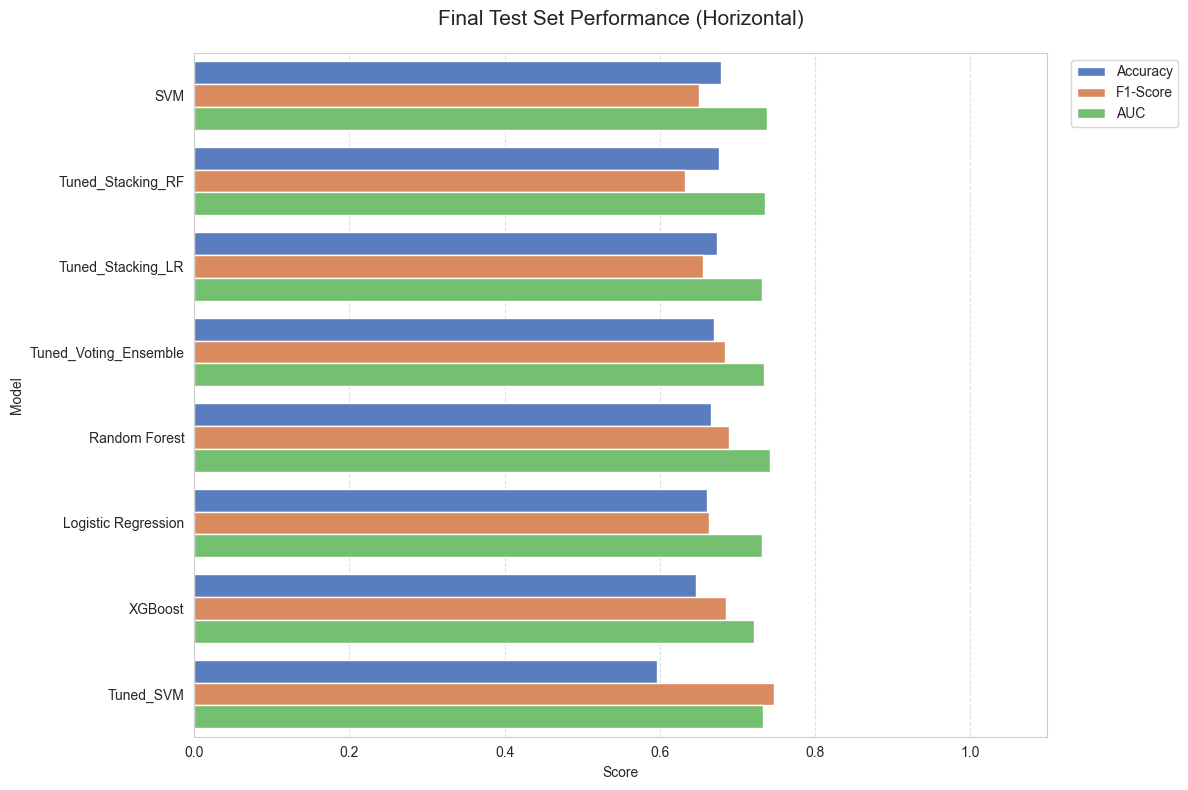

In [361]:
# 시각화
plt.figure(figsize=(12, 8))
df_melted = result_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

sns.barplot(data=df_melted, x='Score', y='Model', hue='Metric', palette='muted')

# 그래프 디테일 설정
plt.title('Final Test Set Performance (Horizontal)', fontsize=15, pad=20)
plt.xlim(0, 1.1)  # 점수 범위 고정
plt.grid(axis='x', linestyle='--', alpha=0.6) # 가로 그래프이므로 x축 그리드 사용
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left') # 범례를 그래프 밖으로 이동
plt.tight_layout()
plt.show()

In [ ]:
all_models = [
    ('Logistic Regression', best_lr),
    ('Random Forest', best_rf),
    ('XGBoost', best_xgb),
    ('SVM', best_svc),
    ('Tuned_Voting_Ensemble', vote_ensemble),
    ('Tuned_Stacking_LR', stacking_lr),
    ('Tuned_Stacking_RF', stacking_rf)
]

In [ ]:
# 1. result_df에서 성능 상위 5개 모델 이름 추출
top_5_model_names = result_df.iloc[:5]['Model'].tolist()
print(f"검증 대상 상위 5개 모델: {top_5_model_names}")

# 2. 모델 객체 매칭을 위한 딕셔너리 생성 (all_models 활용)
model_dict = {name: model for name, model in all_models}

# 3. 상위 5개 모델에 대해 실제 테스트 수행
test_results = []
X = test_df.drop(label, axis=1)
y = test_df[label]
for name in top_5_model_names:
    if name in model_dict:
        model = model_dict[name]
        
        # 실제 예측 수행
        y_pred = model.predict(X)
        
        # 확률값 추출 (AUC 및 상세 분석용)
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X)[:, 1]
        else:
            y_prob = model.decision_function(X)
            
        # 결과 저장
        test_results.append({
            'Model': name,
            'Actual': y.values,
            'Predicted': y_pred,
            'Prob_1': y_prob
        })


검증 대상 상위 5개 모델: ['SVM', 'Tuned_Stacking_RF', 'Tuned_Stacking_LR', 'Tuned_Voting_Ensemble', 'Random Forest']


In [368]:
# 4. 상위 5개 모델 최종 지표 계산 및 시각화 (이름 유연 매칭 버전)
top5_eval_metrics = []

# result_df의 상위 5개 모델 이름을 가져옵니다.
top_5_names_from_df = result_df['Model'].head(5).tolist()
model_dict = {name: model for name, model in all_models}

for name_in_df in top_5_names_from_df:
    target_model = None
    
    # 1. 완전 일치 확인
    if name_in_df in model_dict:
        target_model = model_dict[name_in_df]
    else:
        # 2. 부분 일치 확인 (예: 'Tuned_Stacking_RF'와 'Ensemble_Stacking_RF' 매칭)
        # 핵심 키워드(Stacking_RF, Voting, XGBoost 등)가 포함되어 있는지 확인
        core_name = name_in_df.replace('Tuned_', '').replace('Ensemble_', '')
        for dict_name, obj in model_dict.items():
            if core_name in dict_name or dict_name in name_in_df:
                target_model = obj
                break
                
    if target_model:
        try:
            y_pred = target_model.predict(X_test)
            y_prob = target_model.predict_proba(X_test)[:, 1] if hasattr(target_model, "predict_proba") else target_model.decision_function(X_test)
            
            top5_eval_metrics.append({
                'Model': name_in_df,
                'Accuracy': accuracy_score(y_test, y_pred),
                'F1-Score': f1_score(y_test, y_pred),
                'AUC': roc_auc_score(y_test, y_prob)
            })
        except Exception as e:
            print(f"모델 {name_in_df} 평가 중 오류: {e}")
    else:
        print(f"경고: '{name_in_df}'에 해당하는 객체를 찾을 수 없습니다. (all_models 리스트를 확인해주세요)")

# 데이터프레임 변환 및 출력
top5_test_df = pd.DataFrame(top5_eval_metrics)
print("\n" + "="*50)
print(top5_test_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
print("="*50)


경고: 'Tuned_Voting_Ensemble'에 해당하는 객체를 찾을 수 없습니다. (all_models 리스트를 확인해주세요)

            Model  Accuracy  F1-Score    AUC
              SVM    0.5966    0.7473 0.7295
Tuned_Stacking_RF    0.6761    0.6323 0.7357
Tuned_Stacking_LR    0.6744    0.6563 0.7319
    Random Forest    0.6597    0.6767 0.7342


In [ ]:
# 가로형 시각화
plt.figure(figsize=(10, 6))
df_plot = top5_test_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(data=df_plot, x='Score', y='Model', hue='Metric', palette='muted')
plt.title('Top 5 Models Final Test Performance')
plt.xlim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

KeyError: 'Test_F1'

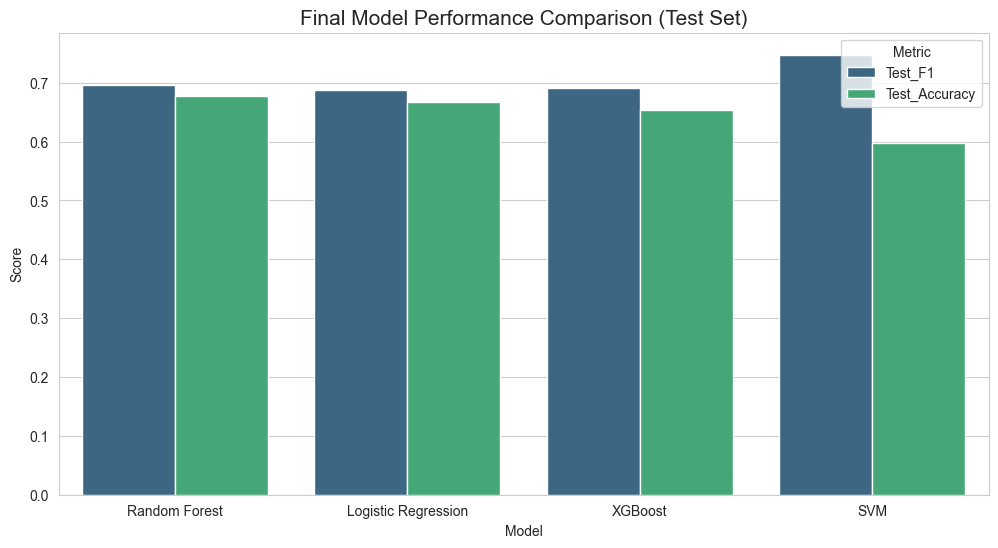

In [359]:
# 4. [보고서용] 시각화 (Bar Chart)
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
melted_df = df_final.melt(id_vars='Model', var_name='Metric', value_name='Score')
ax = sns.barplot(data=melted_df, x='Model', y='Score', hue='Metric', palette='viridis')

plt.title('Final Model Performance Comparison (Test Set)', fontsize=15)
plt.ylim(final_df['Test_F1'].min() - 0.05, 1.0) # 차이를 명확히 보기 위해 하한선 조절
plt.xticks(rotation=45)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [360]:
# 5. 최종 비교표 출력
print("\n" + "="*60)
print(" [ 최종 보고서용 성능 비교표 ]")
print("="*60)
print(final_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
print("="*60)


 [ 최종 보고서용 성능 비교표 ]
               Model  Accuracy  F1-Score    AUC
Ensemble_Stacking_RF    0.6761    0.6323 0.7357
Ensemble_Stacking_LR    0.6744    0.6563 0.7319
 Logistic Regression    0.6608    0.6644 0.7321
       Random Forest    0.6597    0.6767 0.7342
             XGBoost    0.6506    0.6870 0.7326
                 SVM    0.5966    0.7473 0.7295


In [ ]:
# 6. 최우수 모델 상세 리포트 (가장 성적이 좋은 모델)
best_model_name = df_final.iloc[0]['Model']
best_model_obj = dict(all_models)[best_model_name]
print(f"\n🏆 최우수 모델: {best_model_name}")
print(classification_report(y_test, best_model_obj.predict(X_test)))


🏆 최우수 모델: Random Forest
              precision    recall  f1-score   support

           0       0.58      0.76      0.66       887
           1       0.79      0.63      0.70      1313

    accuracy                           0.68      2200
   macro avg       0.69      0.69      0.68      2200
weighted avg       0.71      0.68      0.68      2200



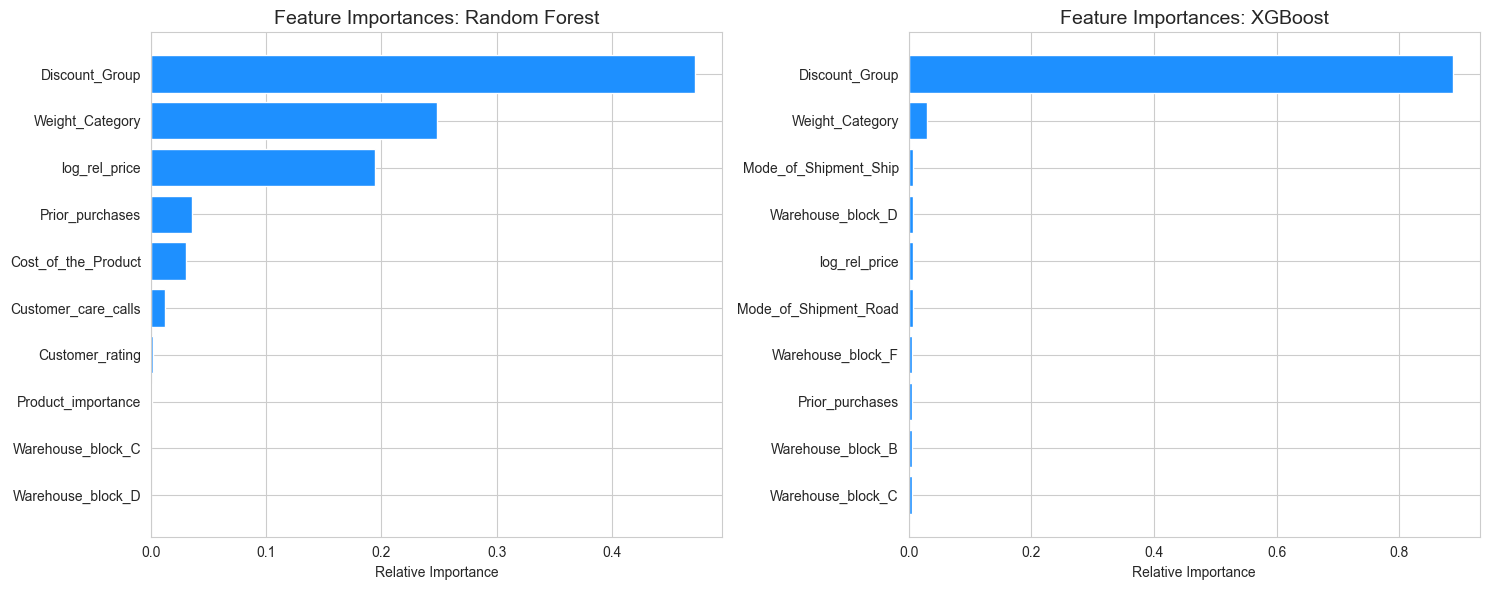

In [ ]:
import numpy as np

# 1. 시각화할 모델 리스트 (트리 기반 모델만 가능)
# Logistic Regression이나 SVM은 회귀 계수(Coefficients)를 사용해야 하므로 제외합니다.
tree_models = [
    ('Random Forest', best_rf),
    ('XGBoost', best_xgb)
]

# 2. 시각화 설정
plt.figure(figsize=(15, 6))

for i, (name, model) in enumerate(tree_models, 1):
    # 변수 중요도 추출 및 정렬
    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:]  # 상위 10개 변수만 추출
    features = X_train.columns

    plt.subplot(1, 2, i)
    plt.title(f'Feature Importances: {name}', fontsize=14)
    plt.barh(range(len(indices)), importances[indices], color='dodgerblue', align='center')
    plt.yticks(range(len(indices)), [features[j] for j in indices])
    plt.xlabel('Relative Importance')

plt.tight_layout()
plt.show()